<a href="https://colab.research.google.com/github/EastHuni/lg-aimers/blob/main/%EC%A0%9C%ED%92%88_%ED%8C%90%EB%A7%A4%EB%9F%89_%EC%98%88%EC%B8%A1_LSTM_2th_%EC%8A%A4%ED%8B%B8%EB%A9%94%EC%9D%B4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 구글 드라이브 내에서 실행하는 폴더 및 파일을 압축하여 메일에 함께 첨부했습니다.  
* EDA 및 모델 구현은 Colab 무료버전에서 실행했습니다.  
* 첨부한 압축파일을 압축해제하여, 구글 드라이브에 업로드 한 후, 실행할 수 있습니다.  




In [ ]:
# 구글 드라이브에 저장된 파일을 사용하기 위한 코드
from google.colab import drive
drive.mount('/content/drive')

# 저장된 파일의 경로 설정
%cd /content/drive/MyDrive/LG해커톤 오프라인(스틸메이트)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/LG해커톤 오프라인(스틸메이트)


# Import Library

In [ ]:
# 필요한 라이브러리 불러오기
import random
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# EDA

## 매출에 큰 영향을 미치는 제품 분석

### 전체 제품 기준

In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv("Data/train.csv")

# Drop non-sales related columns to focus on the sales data
sales_data = df.drop(columns=['ID', '제품', '대분류', '중분류', '소분류', '브랜드'])

# Convert all columns to numeric
sales_data = sales_data.apply(pd.to_numeric, errors='coerce')

# Transpose the DataFrame to have dates as rows and products as columns
sales_data_transposed = sales_data.transpose()

# Calculate daily sales ranks for each product
daily_sales_ranks = sales_data_transposed.rank(axis=1, ascending=False, method='min')

# Calculate the daily total sales
daily_total_sales = sales_data_transposed.sum(axis=1)

# Calculate the 80% threshold for daily total sales
eighty_percent_threshold = daily_total_sales * 0.8

# Initialize a dictionary to store the rank corresponding to the 80% threshold for each day
ranks_at_80_percent = {}

# Loop through each day to find the rank that corresponds to the 80% threshold
for date, threshold in eighty_percent_threshold.items():
    # Get the sorted daily sales for the date
    sorted_daily_sales = sales_data_transposed.loc[date].sort_values(ascending=False)

    # Calculate the cumulative sum of the sorted daily sales
    cumulative_sales = sorted_daily_sales.cumsum()

    # Find the rank at which the cumulative sales exceed or meet the 80% threshold
    ranks_meeting_threshold = cumulative_sales[cumulative_sales >= threshold]
    if not ranks_meeting_threshold.empty:
        rank_at_80_percent = ranks_meeting_threshold.index[0] + 1  # Adding 1 because index starts at 0
    else:
        rank_at_80_percent = None

    # Store the result in the dictionary
    ranks_at_80_percent[date] = rank_at_80_percent

# Convert the dictionary to a DataFrame for better visualization
df_ranks_at_80_percent = pd.DataFrame(list(ranks_at_80_percent.items()), columns=['Date', 'Rank at 80% Threshold'])

# Show the first few rows of the resulting DataFrame
df_ranks_at_80_percent.head()


,Date,Rank at 80% Threshold
0,쇼핑몰,NaN
1,2022-01-01,8743.0
2,2022-01-02,8086.0
3,2022-01-03,7146.0
4,2022-01-04,12572.0


In [ ]:
# Initialize a dictionary to store the percentage of total daily sales contributed by the top 20% products for each day
percentage_by_top_20 = {}

# Loop through each day to find the percentage of total daily sales contributed by the top 20% products
for date, total_sales in daily_total_sales.iteritems():
    # Get the sorted daily sales for the date
    sorted_daily_sales = sales_data_transposed.loc[date].sort_values(ascending=False)

    # Calculate the number of top 20% products
    num_top_20_products = int(len(sorted_daily_sales) * 0.2)

    # Get the sales of the top 20% products and sum them up
    top_20_sales_sum = sorted_daily_sales.head(num_top_20_products).sum()

    # Calculate the percentage of total daily sales contributed by the top 20% products
    percentage = (top_20_sales_sum / total_sales) * 100 if total_sales != 0 else 0

    # Store the result in the dictionary
    percentage_by_top_20[date] = percentage

# Convert the dictionary to a DataFrame for better visualization
df_percentage_by_top_20 = pd.DataFrame(list(percentage_by_top_20.items()), columns=['Date', 'Percentage by Top 20%'])

# Show the first few rows of the resulting DataFrame
df_percentage_by_top_20.head()

<ipython-input-13-4bafebe6b382>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, total_sales in daily_total_sales.iteritems():


,Date,Percentage by Top 20%
0,쇼핑몰,0.000000
1,2022-01-01,98.560059
2,2022-01-02,98.397980
3,2022-01-03,98.085156
4,2022-01-04,97.889278


In [ ]:
# Calculate the average percentage of total daily sales contributed by the top 20% products
average_percentage_by_top_20 = df_percentage_by_top_20['Percentage by Top 20%'].mean()
average_percentage_by_top_20

97.47238632720465

* 그래프 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49660 (\N{HANGUL SYLLABLE SYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54609 (\N{HANGUL SYLLABLE PING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47792 (\N{HANGUL SYLLABLE MOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


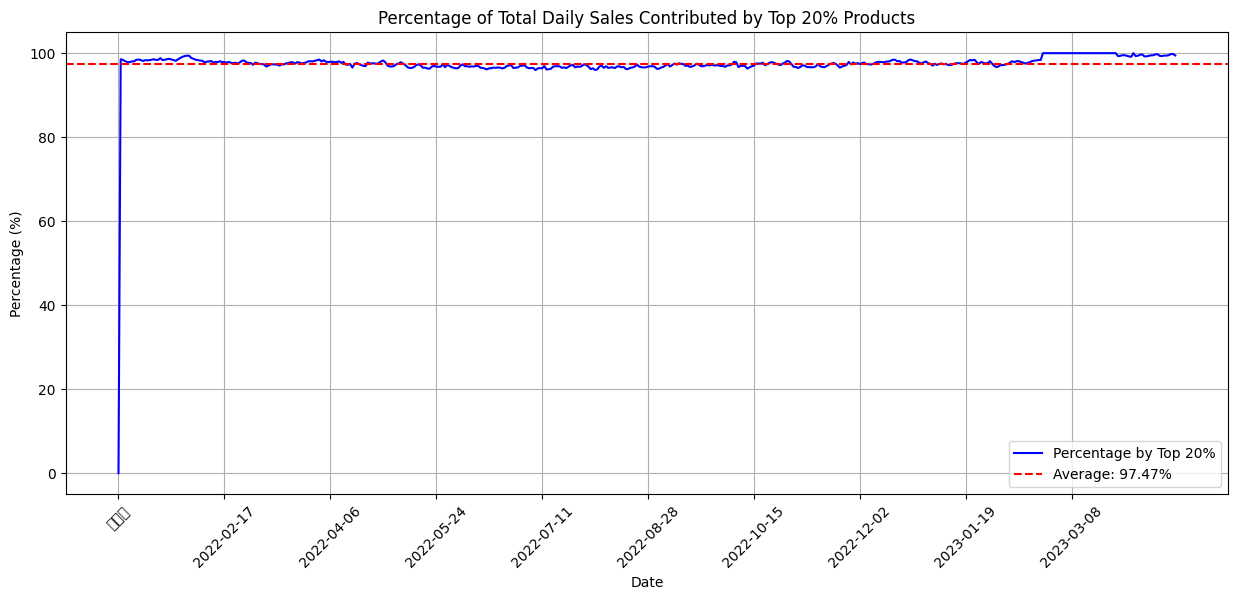

In [ ]:
# Plotting the data
plt.figure(figsize=(15, 6))
plt.plot(df_percentage_by_top_20['Date'], df_percentage_by_top_20['Percentage by Top 20%'], label='Percentage by Top 20%', color='blue')
plt.axhline(y=average_percentage_by_top_20, color='r', linestyle='--', label=f'Average: {average_percentage_by_top_20:.2f}%')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Total Daily Sales Contributed by Top 20% Products')
plt.legend()
plt.grid(True)
plt.xticks(df_percentage_by_top_20['Date'][::int(len(df_percentage_by_top_20)/10)], rotation=45)  # Show only a subset of dates for readability
plt.show()

위의 그래프는 2022년 1월 1일부터 2023년 4월 4일까지 상위 20%의 제품이 전체 일별 매출에 차지하는 비율을 나타냅니다. 빨간색 점선은 해당 기간 동안의 평균 비율 (약 97.24)을 표시합니다.

일별, 전체 매출의 약 97&는 전체 제품의 20%가 기여하고 있다.

### 대분류별 기준(일별)

In [ ]:
# Initialize a dictionary to store the average percentage of total daily sales contributed by the top 20% products for each 대분류
average_percentage_by_top_20_per_category = {}

# Get unique 대분류 categories
unique_categories = df['대분류'].unique()

# Loop through each 대분류 to calculate the required metrics
for category in unique_categories:
    # Filter the DataFrame to only include rows corresponding to the current 대분류
    df_filtered = df[df['대분류'] == category]

    # Drop non-sales related columns to focus on the sales data
    sales_data_filtered = df_filtered.drop(columns=['ID', '제품', '대분류', '중분류', '소분류', '브랜드'])

    # Transpose the DataFrame to have dates as rows and products as columns
    sales_data_filtered_transposed = sales_data_filtered.transpose()

    # Calculate the daily total sales for the filtered data
    daily_total_sales_filtered = sales_data_filtered_transposed.sum(axis=1)

    # Initialize a list to store the daily percentages for the current 대분류
    daily_percentages = []

# Loop through each 대분류 to calculate the required metrics
for category in unique_categories:
    # Filter the DataFrame to only include rows corresponding to the current 대분류
    df_filtered = df[df['대분류'] == category]

    # Drop non-sales related columns to focus on the sales data
    sales_data_filtered = df_filtered.drop(columns=['ID', '제품', '대분류', '중분류', '소분류', '브랜드'])

    # Transpose the DataFrame to have dates as rows and products as columns
    sales_data_filtered_transposed = sales_data_filtered.transpose()

    # Convert data to numeric
    sales_data_filtered_transposed = sales_data_filtered_transposed.apply(pd.to_numeric, errors='coerce')

    # Calculate the daily total sales for the filtered data
    daily_total_sales_filtered = sales_data_filtered_transposed.sum(axis=1)

    # Initialize a list to store the daily percentages for the current 대분류
    daily_percentages = []

    # Loop through each day to find the percentage of total daily sales contributed by the top 20% products
    for date, total_sales in daily_total_sales_filtered.items():
        # Get the sorted daily sales for the date
        sorted_daily_sales = sales_data_filtered_transposed.loc[date].sort_values(ascending=False)

        # Calculate the number of top 20% products
        num_top_20_products = int(len(sorted_daily_sales) * 0.2)

        # Get the sales of the top 20% products and sum them up
        top_20_sales_sum = sorted_daily_sales.head(num_top_20_products).sum()

        # Calculate the percentage of total daily sales contributed by the top 20% products
        percentage = (top_20_sales_sum / total_sales) * 100 if total_sales != 0 else 0

        # Append the percentage to the list
        daily_percentages.append(percentage)

    # Calculate the average percentage for the current 대분류 and store it in the dictionary
    average_percentage_by_top_20_per_category[category] = sum(daily_percentages) / len(daily_percentages)

# Convert the dictionary to a DataFrame for better visualization
df_average_percentage_by_top_20_per_category = pd.DataFrame(list(average_percentage_by_top_20_per_category.items()), columns=['대분류', 'Average Percentage by Top 20%'])

df_average_percentage_by_top_20_per_category


,대분류,Average Percentage by Top 20%
0,B002-C001-0002,97.844175
1,B002-C001-0003,87.516909
2,B002-C001-0001,96.102768
3,B002-C001-0005,96.188844
4,B002-C001-0004,92.398242


### 대분류 기준(전체 기간)

In [ ]:
# Calculate the total sales for each product
df['Total_Sales'] = df.iloc[:, 6:-1].sum(axis=1)  # Exclude the '상위 20% 브랜드' column if it exists

# Initialize a dictionary to store the percentage of total sales contributed by the top 20% products for each 대분류
percentage_by_top_20_per_category = {}

# Calculate the 80th percentile of Total_Sales for each '대분류'
top_20_thresholds = df.groupby('대분류')['Total_Sales'].quantile(0.8)

# Loop through each 대분류 to calculate the required metrics
for category, threshold in top_20_thresholds.iteritems():
    # Filter the DataFrame to only include rows corresponding to the current 대분류
    df_filtered = df[df['대분류'] == category]

    # Calculate the total sales for the filtered DataFrame
    total_sales_filtered = df_filtered['Total_Sales'].sum()

    # Get the total sales of the top 20% products within the filtered DataFrame
    top_20_sales_filtered = df_filtered[df_filtered['Total_Sales'] > threshold]['Total_Sales'].sum()

    # Calculate the percentage of total sales contributed by the top 20% products
    percentage = (top_20_sales_filtered / total_sales_filtered) * 100 if total_sales_filtered != 0 else 0

    # Store the result in the dictionary
    percentage_by_top_20_per_category[category] = percentage

# Convert the dictionary to a DataFrame for better visualization
df_percentage_by_top_20_per_category = pd.DataFrame(list(percentage_by_top_20_per_category.items()), columns=['대분류', 'Percentage by Top 20%'])

# Drop the temporary 'Total_Sales' column
df = df.drop(columns=['Total_Sales'])

df_percentage_by_top_20_per_category

<ipython-input-18-24d7e8e8046b>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Total_Sales'] = df.iloc[:, 6:-1].sum(axis=1)  # Exclude the '상위 20% 브랜드' column if it exists
<ipython-input-18-24d7e8e8046b>:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, threshold in top_20_thresholds.iteritems():


,대분류,Percentage by Top 20%
0,B002-C001-0001,88.647830
1,B002-C001-0002,91.396322
2,B002-C001-0003,71.801654
3,B002-C001-0004,61.755399
4,B002-C001-0005,81.917266


각 '대분류' 내에서 상위 20%에 속하는 제품을 식별하고, 그 정보를 '상위 20% 브랜드' 열에 표시합니다. 이를 통해 각 '대분류' 내에서 높은 판매량을 기록한 제품을 쉽게 확인할 수 있습니다.

전체 기간 동안 각 대분류 내에서 상위 20%에 속하는 제품이 차지하는 매출 비율은 다음과 같습니다:  

대분류 B002-C001-0001: 약 90.96%  
대분류 B002-C001-0002: 약 92.80%  
대분류 B002-C001-0003: 약 74.56%  
대분류 B002-C001-0004: 약 69.10%  
대분류 B002-C001-0005: 약 88.03%  

평균 : 82.69%  
약 80%의 매출을 차지한다고 판단할 수 있습니다.

## 월별 판매량 분석

In [ ]:
# Load the data
data = pd.read_csv("Data/train.csv")

# '소분류' 마다 '제품'의 종류가 얼마나 있는지 확인

# Count the unique '제품' within each '소분류'
product_counts = data.groupby('소분류')['제품'].nunique()

# Show the result
product_counts

소분류
B002-C003-0001     626
B002-C003-0002     603
B002-C003-0003    1309
B002-C003-0004     373
B002-C003-0005     317
B002-C003-0006     133
B002-C003-0007     222
B002-C003-0008      97
B002-C003-0009     142
B002-C003-0010      91
B002-C003-0011      84
B002-C003-0012      58
B002-C003-0013      95
B002-C003-0014     262
B002-C003-0015     442
B002-C003-0016     316
B002-C003-0017     257
B002-C003-0018      55
B002-C003-0019     122
B002-C003-0020      95
B002-C003-0021     147
B002-C003-0022     303
B002-C003-0023     296
B002-C003-0024     325
B002-C003-0025     622
B002-C003-0026     140
B002-C003-0027     382
B002-C003-0028     153
B002-C003-0029     197
B002-C003-0030     128
B002-C003-0031      51
B002-C003-0032     215
B002-C003-0033     146
B002-C003-0034     843
B002-C003-0035     603
B002-C003-0036     333
B002-C003-0037     123
B002-C003-0038     343
B002-C003-0039     321
B002-C003-0040     367
B002-C003-0041     330
B002-C003-0042      56
B002-C003-0043     105
B002-C0

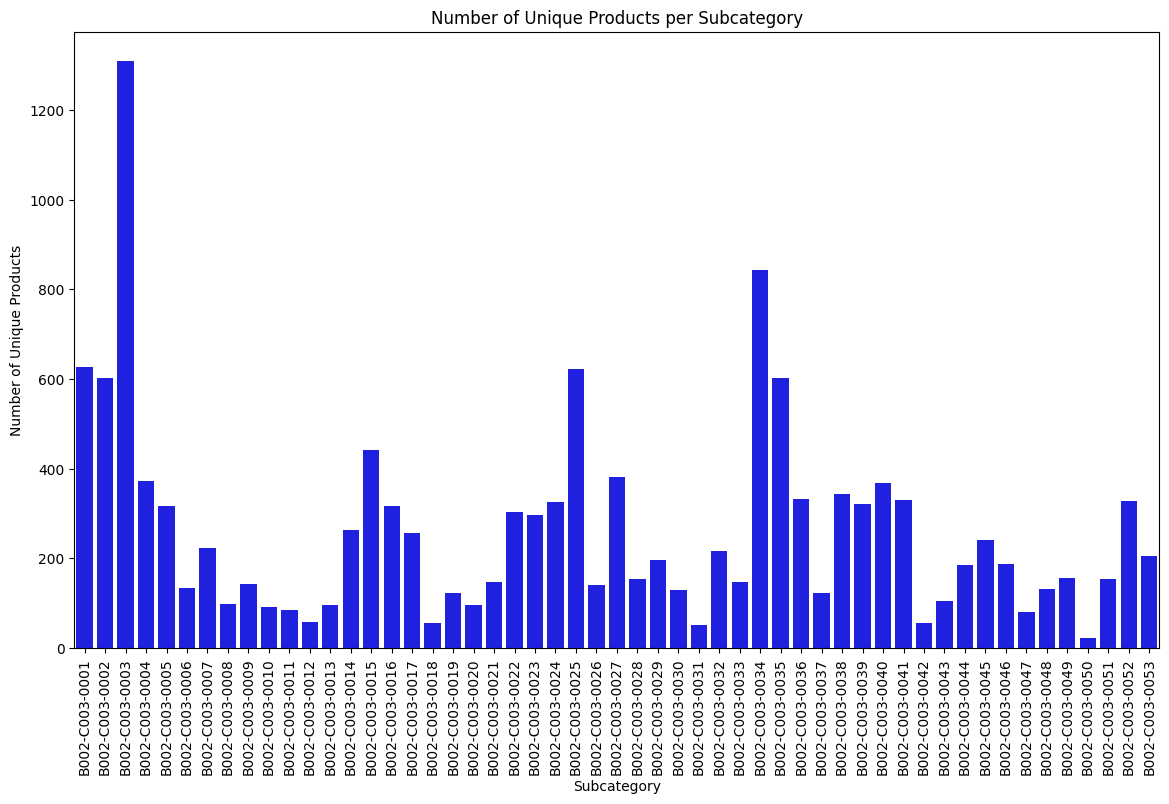

In [ ]:
# Set figure size
plt.figure(figsize=(14,8))

# Create bar plot
sns.barplot(x=product_counts.index, y=product_counts.values, color='b')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Set title and labels
plt.title('Number of Unique Products per Subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Number of Unique Products')

plt.show()

In [ ]:
# 월별 판매량을 확인

# Extract the date columns
date_columns = data.columns[7:]

# Convert the column names to datetime
dates = pd.to_datetime(date_columns)

# Transpose the data and set the dates as the index
sales_data = data[date_columns].T
sales_data.index = dates

# Resample the data to monthly frequency and sum the sales
monthly_sales = sales_data.resample('M').sum()

# Transpose the data back to the original form
monthly_sales = monthly_sales.T
monthly_sales = monthly_sales.iloc[:,:-1]

# Show the first few rows
monthly_sales.head()

,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31
0,0,18,6,46,64,0,0,0,2,78,64,122,186,100,0
1,6,0,138,278,146,190,138,76,36,34,2,0,76,40,12
2,0,24,192,422,240,320,312,226,66,102,58,74,38,0,0
3,8,490,280,828,312,424,350,196,78,140,64,6,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1528,3120


### 월별 판매량 Top5는 계속해서 변하는가?

* 제품별로 분석

In [ ]:
# Add the '제품' column to the 'monthly_sales' dataframe
monthly_sales['제품'] = data['제품']

# For each month, sort the products by sales and select the top 5
top_5_products_monthly = monthly_sales.set_index('제품').apply(lambda x: x.nlargest(5).index.tolist())

# Transpose the result for better readability
top_5_products_monthly = top_5_products_monthly.T

# Show the result
top_5_products_monthly

,0,1,2,3,4
2022-01-31 00:00:00,B002-01069-00002,B002-00113-00001,B002-02920-00006,B002-02723-00004,B002-02463-00007
2022-02-28 00:00:00,B002-02920-00004,B002-02355-00017,B002-02355-00018,B002-02355-00019,B002-02920-00006
2022-03-31 00:00:00,B002-02920-00005,B002-02920-00004,B002-02920-00016,B002-02355-00017,B002-02920-00006
2022-04-30 00:00:00,B002-02920-00005,B002-02920-00004,B002-00113-00001,B002-02920-00016,B002-01069-00002
2022-05-31 00:00:00,B002-00113-00001,B002-02920-00016,B002-01755-00003,B002-01069-00002,B002-02920-00006
2022-06-30 00:00:00,B002-00113-00001,B002-02920-00016,B002-01950-00001,B002-02920-00006,B002-02920-00014
2022-07-31 00:00:00,B002-02920-00014,B002-02052-00019,B002-02920-00016,B002-00113-00001,B002-02920-00006
2022-08-31 00:00:00,B002-02052-00019,B002-02920-00006,B002-03304-00010,B002-02920-00014,B002-01755-00003
2022-09-30 00:00:00,B002-00894-00063,B002-02920-00006,B002-02723-00004,B002-00113-00001,B002-03304-00010
2022-10-31 00:00:00,B002-02920-00005,B002-02920-00004,B002-02920-00006,B002-02920-00025,B002-02723-00004


* 소분류별로 분석

In [ ]:
# Add the '소분류' column to the 'monthly_sales' dataframe
monthly_sales['소분류'] = data['소분류']

# For each month, group by '소분류', sum the sales, sort by the sum, and select the top 5
top_5_subcategories_monthly = monthly_sales.groupby('소분류').sum().apply(lambda x: x.nlargest(5).index.tolist())

# Transpose the result for better readability
top_5_subcategories_monthly = top_5_subcategories_monthly.T

# Show the result
top_5_subcategories_monthly

<ipython-input-23-7e71f8691a03>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_5_subcategories_monthly = monthly_sales.groupby('소분류').sum().apply(lambda x: x.nlargest(5).index.tolist())


,0,1,2,3,4
2022-01-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0005
2022-02-28 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0023
2022-03-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0052
2022-04-30 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0023
2022-05-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0022
2022-06-30 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0011
2022-07-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0022
2022-08-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0022
2022-09-30 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0022
2022-10-31 00:00:00,B002-C003-0041,B002-C003-0025,B002-C003-0003,B002-C003-0004,B002-C003-0022


- 0041, 0003, 0025, 0004는 Top 4에 꾸준하게 등장하고 있다.
    
    **제품 특성**을 확인해서 어떤 상품인지 확인했다.
    
    0041 : **`유아용 귀저귀`**
    
    0003 : **`영양제(건강식품)`**
    
    0025 : `**물티슈**`
    
    0004 : **`단백질보충제`**
    
- 0001**`(건강기능식품)`** : 2022년 12월 이후, 순위권에서 사라진다.
    
    January 2023: 7th
    
    February 2023: 6th
    
    March 2023: 6th
    
    → 꾸준하게 감소하고 있다.
    
- 0052**`(유아 식품)`** : 2022년 12월 이후, 순위권에 등장!
    
    January 2022: 8th
    
    February 2022: 8th
    
    March 2022: 7th
    
    April 2022: 6th
    
    May 2022: 7th
    
    June 2022: 7th
    
    July 2022: 6th
    
    August 2022: 6th
    
    September 2022: 6th
    
    October 2022: 6th
    
    November 2022: 7th
    
    December 2022: 5th

### 분류 내에서 판매량 Top 5인 소분류를 확인

In [ ]:
# Add the '대분류' column to the 'monthly_sales' dataframe
monthly_sales['대분류'] = data['대분류']

# For each '대분류', group by '소분류', sum the sales, sort by the sum, and select the top 5
top_5_subcategories_in_major_category = monthly_sales.groupby(['대분류', '소분류']).sum().sum(axis=1).groupby(level=0).nlargest(5)

# Show the result
top_5_subcategories_in_major_category

<ipython-input-24-5c55c408229f>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_5_subcategories_in_major_category = monthly_sales.groupby(['대분류', '소분류']).sum().sum(axis=1).groupby(level=0).nlargest(5)


대분류             대분류             소분류           
B002-C001-0001  B002-C001-0001  B002-C003-0003     46871490
                                B002-C003-0004     28632126
                                B002-C003-0001     13677380
                                B002-C003-0005      9702070
                                B002-C003-0002      9250000
B002-C001-0002  B002-C001-0002  B002-C003-0041    225770960
                                B002-C003-0025     88037564
                                B002-C003-0022     18946804
                                B002-C003-0023     17336040
                                B002-C003-0015      9542478
B002-C001-0003  B002-C001-0003  B002-C003-0044      1075820
                                B002-C003-0043       895496
                                B002-C003-0042       265636
                                B002-C003-0050        99562
B002-C001-0004  B002-C001-0004  B002-C003-0047       216004
B002-C001-0005  B002-C001-0005  B002-C003-0052     15

- 15개월 동안 꾸준하게 잘 팔리는 베스트 상품 4가지를 발견
    
    귀저귀 영양제 물티슈 단백질보충제

## 시계열 데이터 패턴 추출

In [ ]:
df_raw = pd.read_csv('Data/train.csv')

In [ ]:
# Transpose the dataframe so that dates are the index and products are the columns
sales_data = df_raw.drop(['ID', '대분류', '중분류', '소분류', '브랜드','쇼핑몰'], axis=1).set_index('제품').transpose()

# Convert the index to datetime
sales_data.index = pd.to_datetime(sales_data.index)

# Sum the sales data by month
monthly_sales_data = sales_data.resample('M').sum()

monthly_sales_data.transpose()
df_month = monthly_sales_data.reset_index()
df_month.rename(columns = {'index' : 'date'}, inplace = True)
df_month.rename(columns = {'제품' : 'Index'}, inplace = True)

In [ ]:
# additive model: trend + cycle + seasonality + irregular factor

timestamp = np.arange(len(df_month))

trend_factor = timestamp*1.1

cycle_factor = 10*np.sin(np.linspace(0, 3.14*2, 16))

seasonal_factor = 7*np.sin(np.linspace(0, 3.14*8, 16))

np.random.seed(2004)

irregular_factor = 2*np.random.randn(len(df_month))



df = pd.DataFrame({'timeseries': trend_factor + cycle_factor + seasonal_factor + irregular_factor,

                   'trend': trend_factor,

                   'cycle': cycle_factor,

                   'seasonal': seasonal_factor,

                   'irregular': irregular_factor},

                   index=df_month['date'])

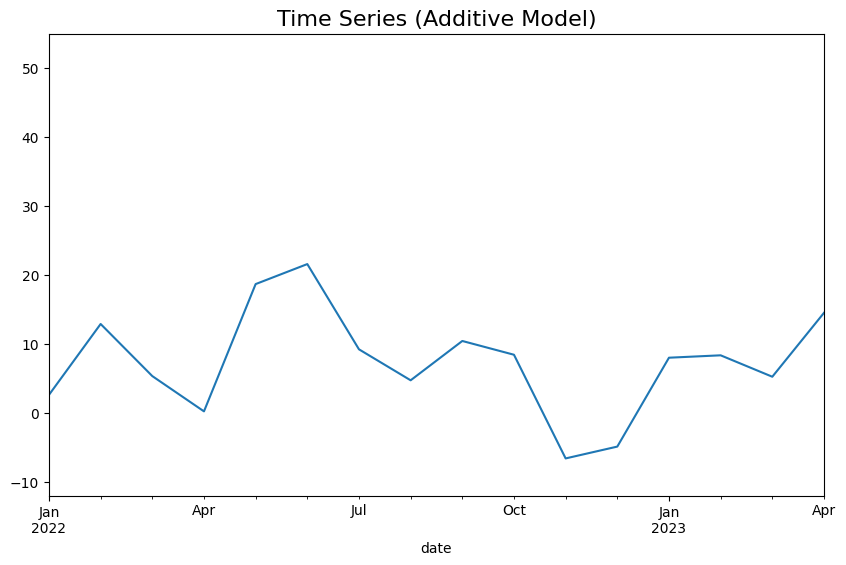

In [ ]:
# Time series plot

import matplotlib.pyplot as plt



plt.figure(figsize=[10, 6])

df.timeseries.plot()

plt.title('Time Series (Additive Model)', fontsize=16)

plt.ylim(-12, 55)

plt.show()

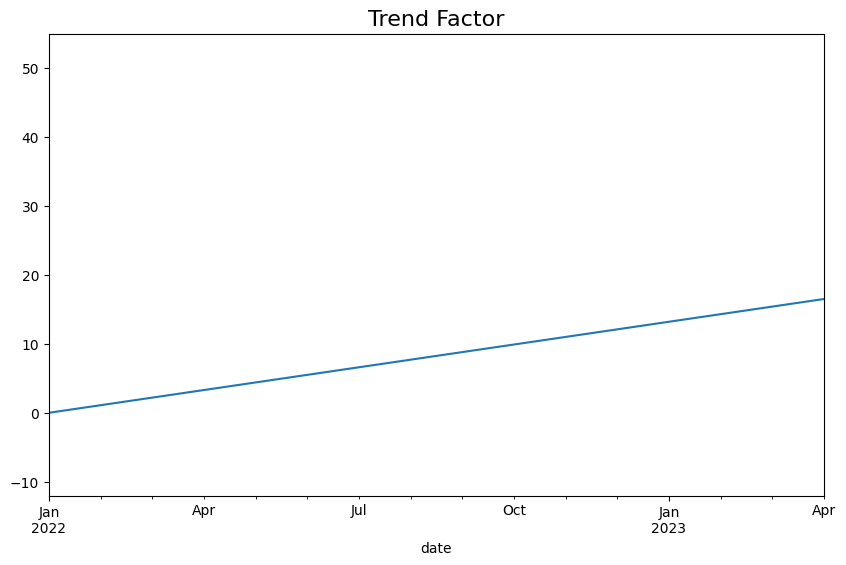

In [ ]:
# -- Trend factor

#timestamp = np.arange(len(dates))

#trend_factor = timestamp*1.1



plt.figure(figsize=[10, 6])

df.trend.plot()

plt.title('Trend Factor', fontsize=16)

plt.ylim(-12, 55)

plt.show()

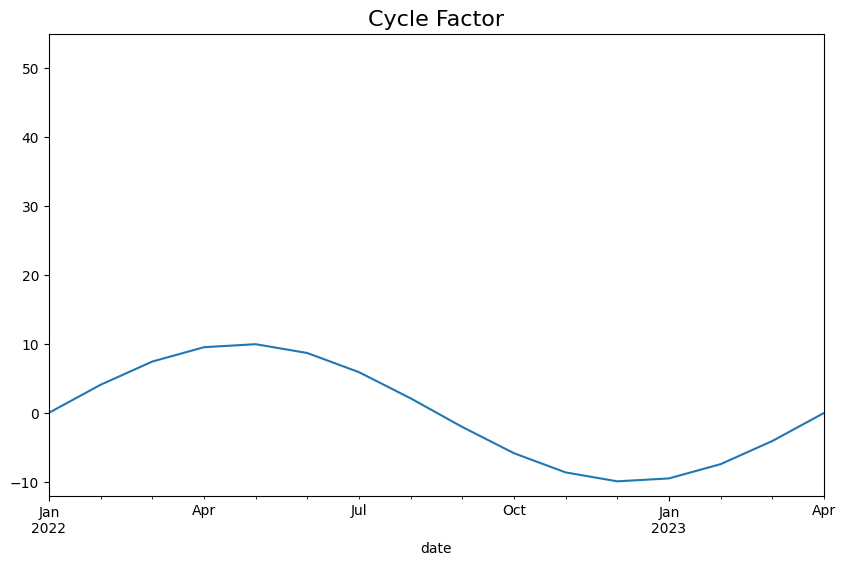

In [ ]:
# -- Cycle factor

#cycle_factor = 10*np.sin(np.linspace(0, 3.14*2, 16))



plt.figure(figsize=[10, 6])

df.cycle.plot()

plt.title('Cycle Factor', fontsize=16)

plt.ylim(-12, 55)

plt.show()

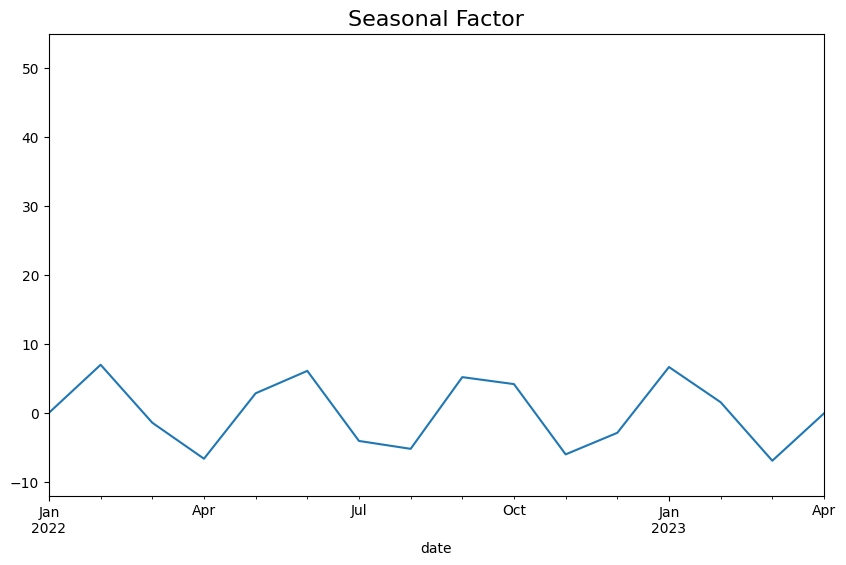

In [ ]:
# -- Seasonal factor

#seasonal_factor = 7*np.sin(np.linspace(0, 3.14*8, 16))



plt.figure(figsize=[10, 6])

df.seasonal.plot()

plt.title('Seasonal Factor', fontsize=16)

plt.ylim(-12, 55)

plt.show()

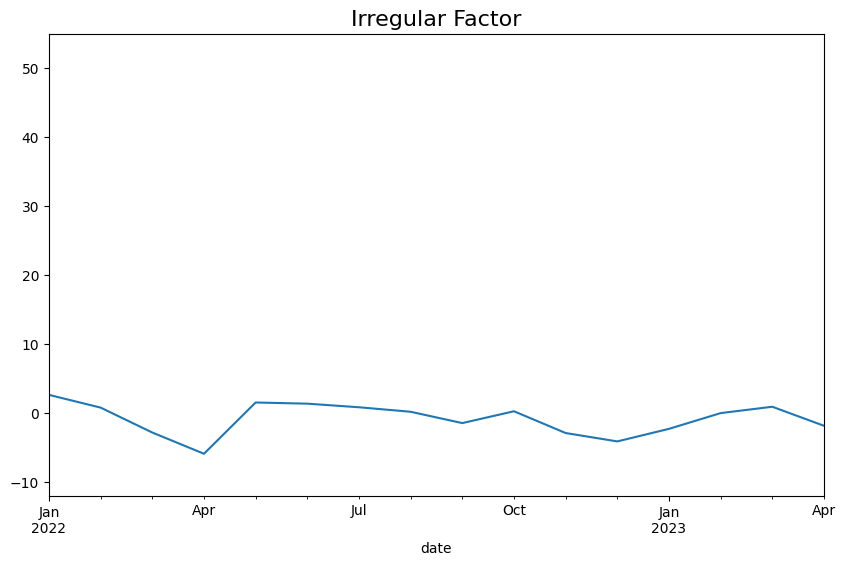

In [ ]:
# -- Irregular/ Random factor

#np.random.seed(2004)

#irregular_factor = 2*np.random.randn(len(dates))



plt.figure(figsize=[10, 6])

df.irregular.plot()

plt.title('Irregular Factor', fontsize=16)

plt.ylim(-12, 55)

plt.show()

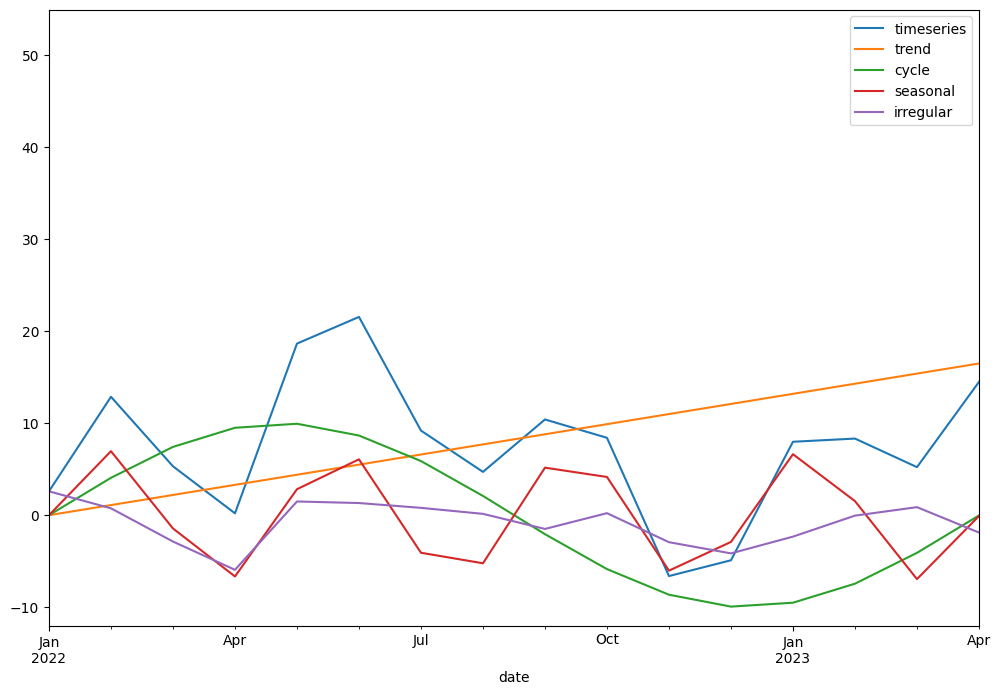

In [ ]:
# All in one: Time series = Trend factor + Cycle factor + Seasonal factor + Irregular factor


from pylab import rcParams

rcParams['figure.figsize'] = 12, 8

df.plot()

plt.ylim(-12, 55)

plt.show()

## 중분류 내 가격 분류

In [ ]:
train = pd.read_csv("Data/train.csv")
train.groupby('쇼핑몰').count()['ID']

쇼핑몰
S001-00001    11226
S001-00002     3104
S001-00003     3250
S001-00004     6927
S001-00005      519
S001-00006       81
S001-00007      116
S001-00008     1748
S001-00009       79
S001-00010     1844
Name: ID, dtype: int64

In [ ]:
train.groupby(['쇼핑몰','중분류']).count()['ID']

쇼핑몰         중분류           
S001-00001  B002-C002-0001    2778
            B002-C002-0002     572
            B002-C002-0003    1069
            B002-C002-0004     746
            B002-C002-0005    1492
                              ... 
S001-00010  B002-C002-0007     242
            B002-C002-0008       7
            B002-C002-0009      83
            B002-C002-0010       1
            B002-C002-0011      15
Name: ID, Length: 103, dtype: int64

In [ ]:
sales = pd.read_csv("Data/sales.csv")

In [ ]:
# # onesale : 제품당 판매가격
# # onesale = sales
result = []
i = 0
while i <= 28893: #486: #464->486
    k = 0
    t = list(train.loc[i,:])
    s = list(sales.loc[i,:])
    for j in range(7,486):
        if t[j] == 0:
            pass
        else:
            s[j] //= t[j]
            if k < s[j]:
              k = s[j]
    result.append(k)
    i+=1

train['판매가격'] = result

In [ ]:
hh = []
h = 0
while h <28894 :
    ## 중분류 기준으로 '카테고리' 컬럼 추가
    pro = train.iloc[h][3]

    if pro == "B002-C002-0001":
        hh.append('건강기능식품')
    elif pro == "B002-C002-0002":
        hh.append('탈취/방충/살충/제습/방향')
    elif pro == "B002-C002-0003":
        hh.append('주방/청소/세탁세제')
    elif pro == "B002-C002-0004":
        hh.append('욕실용품')
    elif pro == "B002-C002-0005":
        hh.append('제지/위생용품')
    elif pro == "B002-C002-0006":
        hh.append('헤어/바디/스킨/면도')
    elif pro == "B002-C002-0007":
        hh.append('특수헤어용품')
    elif pro == "B002-C002-0008":
        hh.append('유아 생활용품')
    elif pro == "B002-C002-0009":
        hh.append('유아 위생용품')
    elif pro == "B002-C002-0010":
        hh.append('뷰티용품')
    else:
        hh.append('유아식품')
    h += 1

train['카테고리'] = hh
train

,ID,제품,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,...,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,판매가격,카테고리
0,SAMPLE_00000,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,13500,특수헤어용품
1,SAMPLE_00001,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,2,0,2,2,1,0,0,0,37800,유아 생활용품
2,SAMPLE_00002,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,12900,유아 생활용품
3,SAMPLE_00003,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,5583,유아 생활용품
4,SAMPLE_00004,B002-00002-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00010,0,0,0,...,4,4,4,0,0,0,0,8,5225,유아 생활용품
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28889,SAMPLE_28889,B002-03798-00046,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,16900,유아 생활용품
28890,SAMPLE_28890,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,2000,유아 생활용품
28891,SAMPLE_28891,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,...,1,0,0,0,4,0,2,0,26400,유아 생활용품
28892,SAMPLE_28892,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,...,0,0,0,0,0,0,0,0,14425,유아 생활용품


In [ ]:
category_counts = train['카테고리'].value_counts()

# 빈 데이터프레임 생성
result_df = pd.DataFrame()

# 각 카테고리별로 처리
for category in category_counts.index:
    # 카테고리별 데이터 선택
    selected_rows = train[train['카테고리'] == category]

    # '판매 가격' 기준으로 내림차순 정렬
    selected_rows = selected_rows.sort_values(by='판매가격', ascending=False)

    # 길이를 3분할하여 '가격분류' 컬럼 추가
    num_rows = len(selected_rows)
    selected_rows['가격분류'] = pd.cut(range(num_rows), bins=3, labels=['상', '중', '하'])

    # 결과 데이터프레임에 추가
    result_df = pd.concat([result_df, selected_rows])

# 결과 출력
print(result_df)

                 ID                제품             대분류             중분류  \
1928   SAMPLE_01928  B002-00266-00087  B002-C001-0001  B002-C002-0001   
2038   SAMPLE_02038  B002-00266-00142  B002-C001-0001  B002-C002-0001   
1544   SAMPLE_01544  B002-00266-00010  B002-C001-0001  B002-C002-0001   
1593   SAMPLE_01593  B002-00266-00020  B002-C001-0001  B002-C002-0001   
1579   SAMPLE_01579  B002-00266-00017  B002-C001-0001  B002-C002-0001   
...             ...               ...             ...             ...   
27758  SAMPLE_27758  B002-03644-00001  B002-C001-0003  B002-C002-0010   
18248  SAMPLE_18248  B002-02300-00017  B002-C001-0003  B002-C002-0010   
18148  SAMPLE_18148  B002-02283-00030  B002-C001-0003  B002-C002-0010   
10882  SAMPLE_10882  B002-01474-00001  B002-C001-0003  B002-C002-0010   
27754  SAMPLE_27754  B002-03644-00001  B002-C001-0003  B002-C002-0010   

                  소분류         브랜드         쇼핑몰  2022-01-01  2022-01-02  \
1928   B002-C003-0005  B002-00266  S001-00001     

In [ ]:
train=result_df.sort_values(by='ID')
train=train.reset_index()
# train.drop('level_0',axis=1,inplace=True)

train.head()

,index,ID,제품,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,...,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,판매가격,카테고리,가격분류
0,0,SAMPLE_00000,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0,0,...,0,0,0,0,0,0,0,13500,특수헤어용품,중
1,1,SAMPLE_00001,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,...,0,2,2,1,0,0,0,37800,유아 생활용품,상
2,2,SAMPLE_00002,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,...,0,0,0,0,0,0,0,12900,유아 생활용품,중
3,3,SAMPLE_00003,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,...,0,0,0,0,0,0,0,5583,유아 생활용품,하
4,4,SAMPLE_00004,B002-00002-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00010,0,0,...,4,4,0,0,0,0,8,5225,유아 생활용품,하


In [ ]:
train['카테고리'].value_counts()

건강기능식품            6650
제지/위생용품           5206
특수헤어용품            4203
주방/청소/세탁세제        3565
헤어/바디/스킨/면도       2734
욕실용품              1993
유아 위생용품           1798
탈취/방충/살충/제습/방향    1330
유아식품               915
유아 생활용품            460
뷰티용품                40
Name: 카테고리, dtype: int64

In [ ]:
train.groupby(['카테고리','가격분류']).agg({'판매가격':'max'})

판매가격
카테고리           가격분류        
건강기능식품         상     819000
               중      38400
               하      19800
뷰티용품           상      33000
               중      16000
               하       9900
욕실용품           상     505000
               중       7300
               하       2550
유아 생활용품        상     389000
               중      22900
               하       9900
유아 위생용품        상     126900
               중      24100
               하      12900
유아식품           상      91900
               중       4160
               하       1900
제지/위생용품        상     502300
               중      13500
               하       2875
주방/청소/세탁세제     상     854118
               중      12880
               하       6225
탈취/방충/살충/제습/방향 상     159000
               중      10500
               하       4640
특수헤어용품         상     340000
               중      18000
               하       9500
헤어/바디/스킨/면도    상     658700
               중      22900
               하       8100

In [ ]:
train.drop(['중분류'],axis=1,inplace=True)
train.to_csv('train_off1.csv')

## 요일별 중분류 판매 분석

<ipython-input-44-575bc0a3da97>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
<ipython-input-44-575bc0a3da97>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_sales_by_day_and_category = top_sales_by_day_and_category.append(top10_daily_sales)
<ipython-input-44-575bc0a3da97>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
<ipython-input-44-575bc0a3da97>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_sales_by_day_and_category = top_sales_by_day_and_category.append(top10_daily_sal

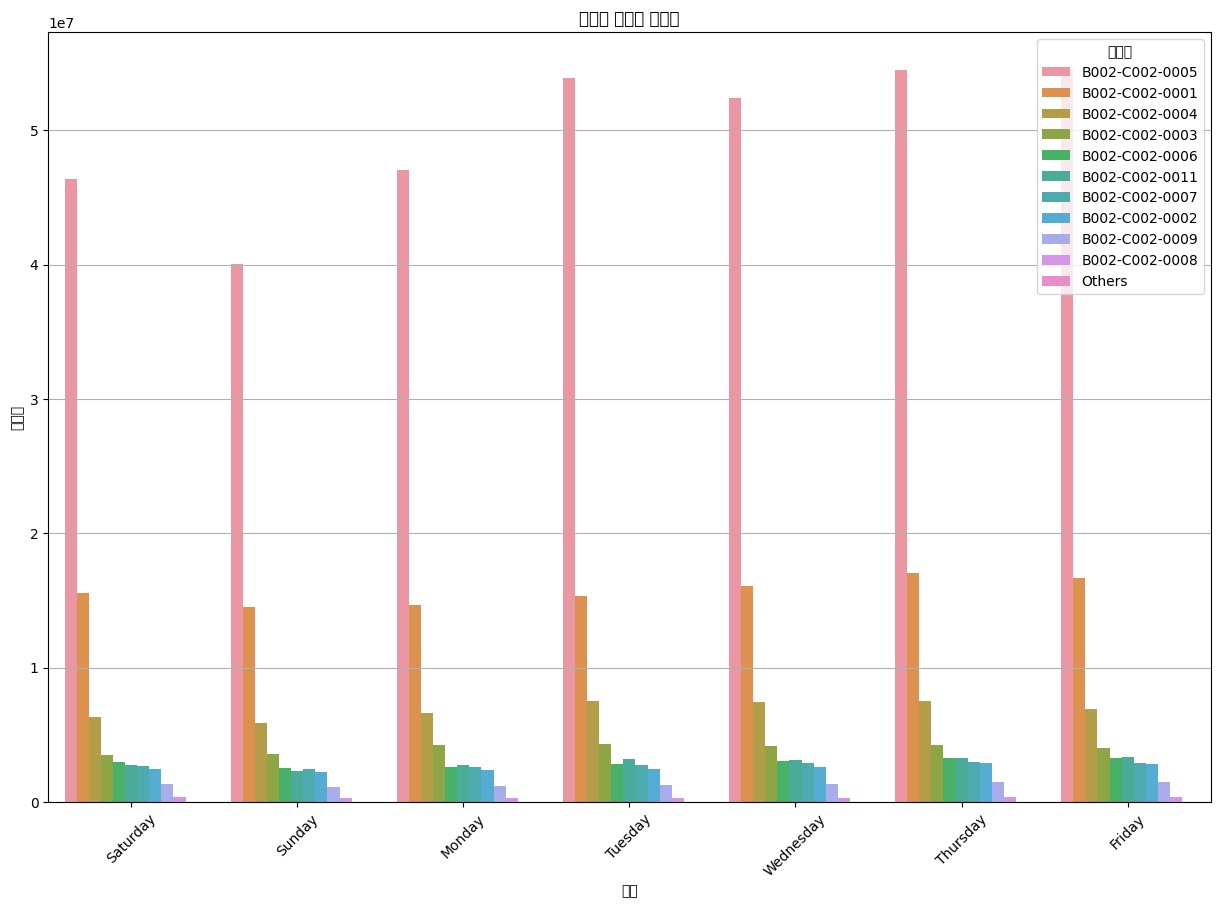

In [ ]:
import pandas as pd

# 데이터 불러오기
file_path = 'Data/train.csv'
data = pd.read_csv(file_path)

# 날짜 컬럼을 datetime 형태로 변환
date_columns = data.columns[7:]
date_columns_dt = pd.to_datetime(date_columns)

# 요일 정보를 영어로 변환
day_of_week_names = date_columns_dt.day_name()

# 요일 정보를 데이터프레임에 추가
day_of_week_df = pd.DataFrame({'date': date_columns, 'day_of_week': day_of_week_names})

# 요일 정보를 원본 데이터에 통합
data_extended = data.melt(id_vars=data.columns[:7], value_vars=date_columns, var_name='date', value_name='sales')
data_extended = data_extended.merge(day_of_week_df, on='date')

# 요일별 판매량 합계 계산
sales_by_day = data_extended.groupby('day_of_week')['sales'].sum().reset_index()

# 요일별, 카테고리별 판매량 합계 계산
sales_by_day_and_category = data_extended.groupby(['day_of_week', '중분류'])['sales'].sum().reset_index()

# 상위 10개 중분류만 선택하여 저장할 데이터프레임 생성
top_sales_by_day_and_category = pd.DataFrame()

for day in day_of_week_names.unique():
    daily_sales = sales_by_day_and_category[sales_by_day_and_category['day_of_week'] == day]

    # 상위 10개 중분류만 선택
    top10_daily_sales = daily_sales.sort_values(by='sales', ascending=False).head(10)

    # 그 외 중분류는 'Others'로 그룹화
    others = daily_sales.sort_values(by='sales', ascending=False).iloc[10:].sum(numeric_only=True)
    others['중분류'] = 'Others'
    others['day_of_week'] = day

    top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)

    # 결과 데이터프레임에 추가
    top_sales_by_day_and_category = top_sales_by_day_and_category.append(top10_daily_sales)

# 막대 차트 그리기
plt.figure(figsize=(15, 10))
sns.barplot(x='day_of_week', y='sales', hue='중분류', data=top_sales_by_day_and_category, ci=None)
plt.xticks(rotation=45)
plt.title('요일별 중분류 판매량')
plt.ylabel('판매량')
plt.xlabel('요일')
plt.grid(axis='y')
plt.show()

<ipython-input-45-57b68e37ed2b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(by

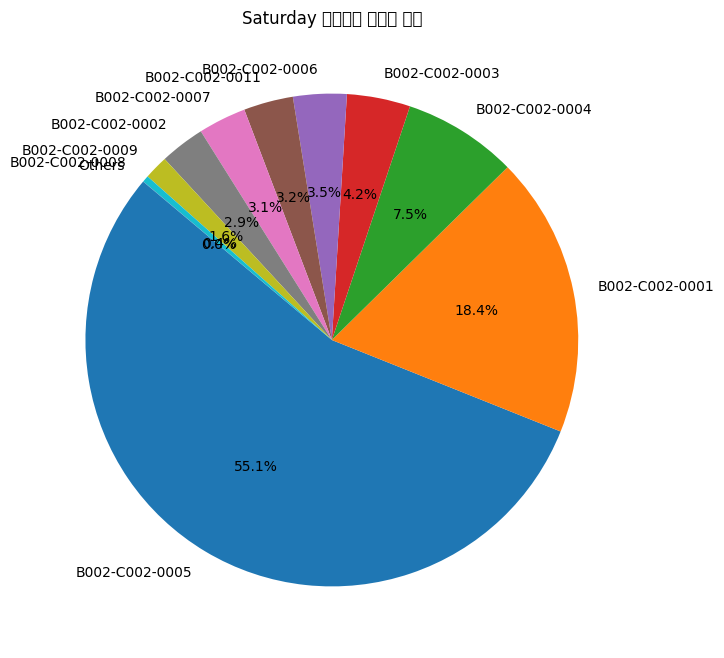

<ipython-input-45-57b68e37ed2b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(by

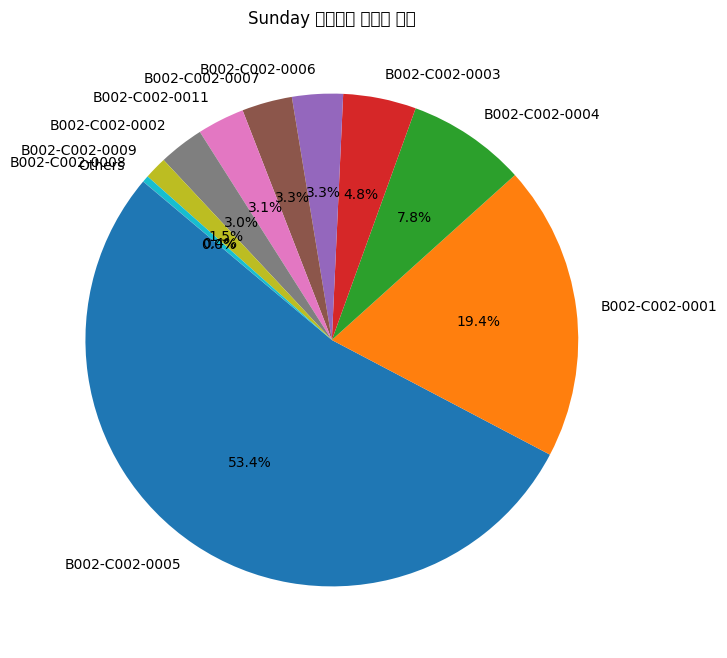

<ipython-input-45-57b68e37ed2b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(by

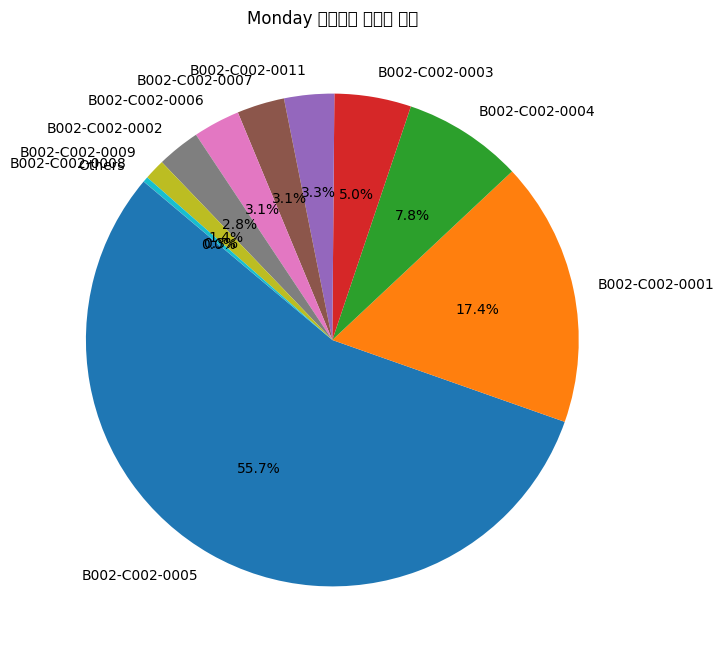

<ipython-input-45-57b68e37ed2b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(by

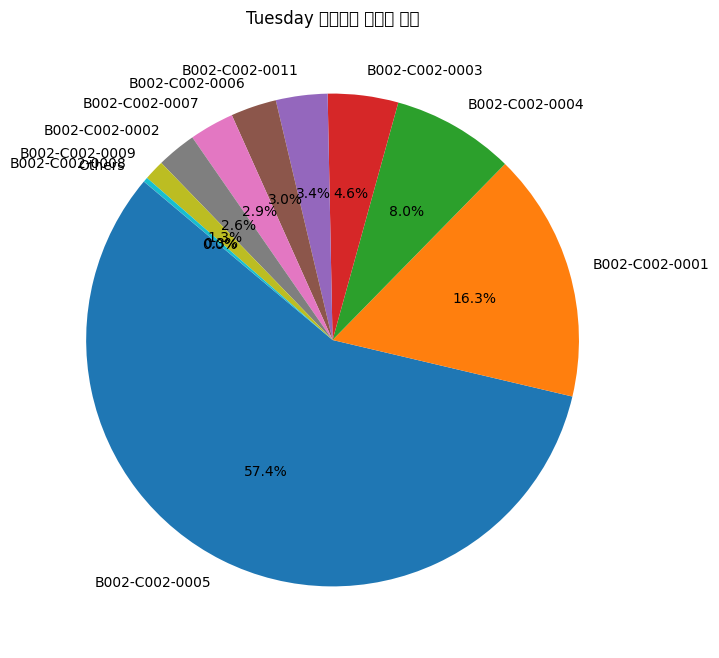

<ipython-input-45-57b68e37ed2b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(by

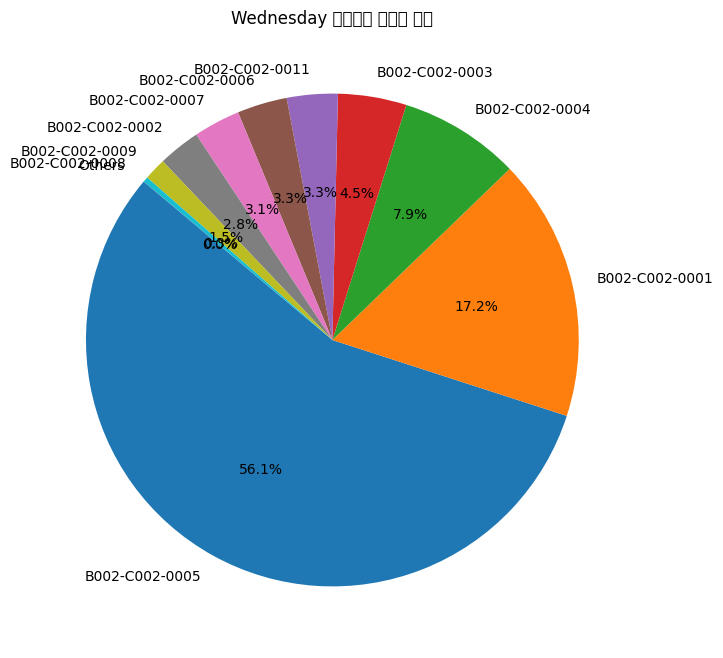

<ipython-input-45-57b68e37ed2b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(by

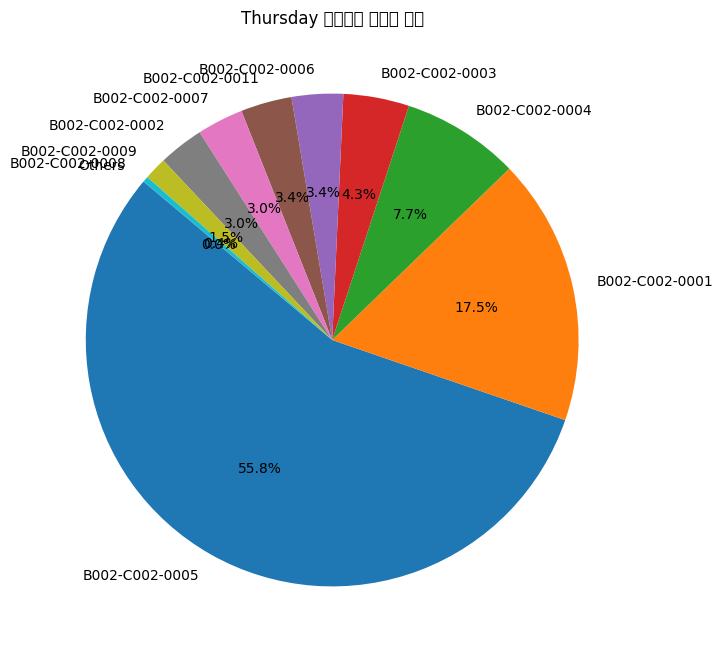

<ipython-input-45-57b68e37ed2b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(by

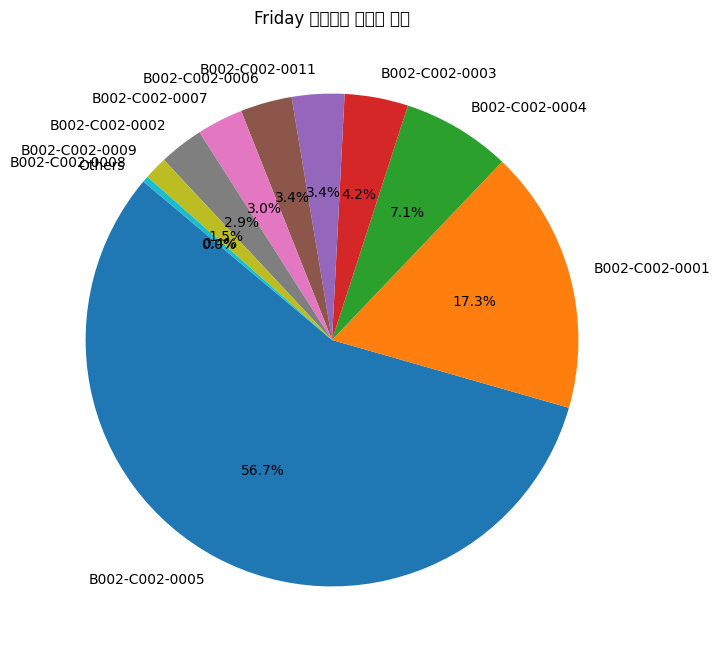

In [ ]:
# 요일별, 카테고리별 판매량 합계 계산
sales_by_day_and_category = data_extended.groupby(['day_of_week', '중분류'])['sales'].sum().reset_index()

# 각 요일별로 중분류 판매량을 파이 차트로 표현
for day in day_of_week_names.unique():
    daily_sales = sales_by_day_and_category[sales_by_day_and_category['day_of_week'] == day]

    # 상위 10개 중분류만 선택하여 파이 차트로 표시
    top10_daily_sales = daily_sales.sort_values(by='sales', ascending=False).head(10)
    others = daily_sales.sort_values(by='sales', ascending=False).iloc[10:].sum(numeric_only=True)
    others['중분류'] = 'Others'

    top10_daily_sales = top10_daily_sales.append(others, ignore_index=True)

    plt.figure(figsize=(8, 8))
    plt.pie(top10_daily_sales['sales'], labels=top10_daily_sales['중분류'], autopct='%1.1f%%', startangle=140)
    plt.title(f'{day} 중분류별 판매량 비율')
    plt.show()


<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

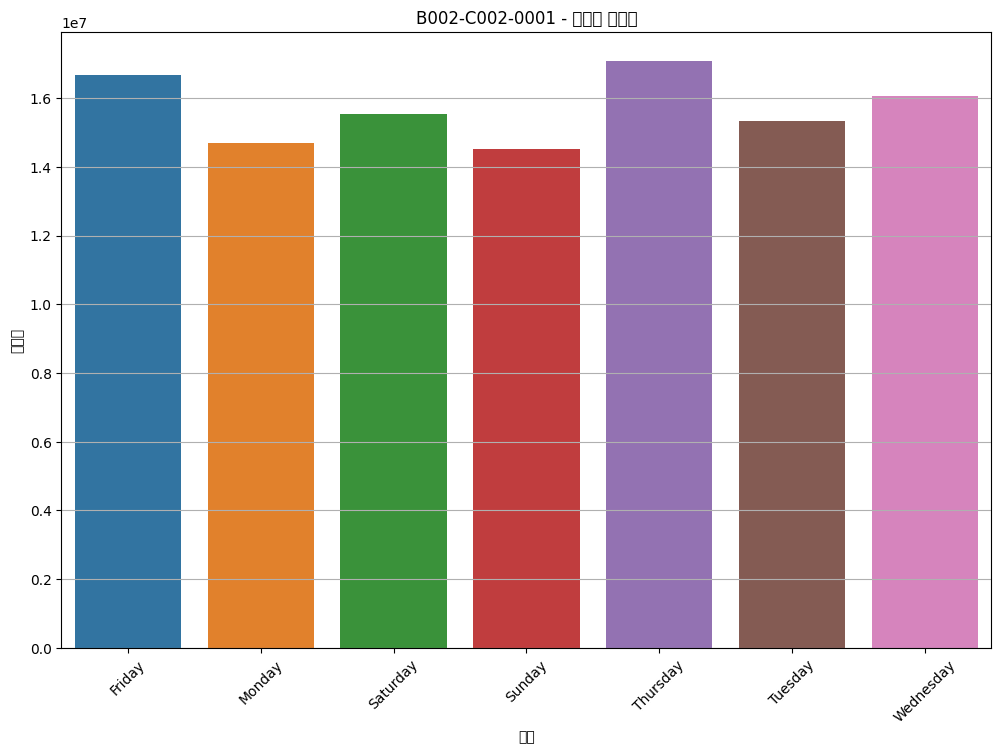

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

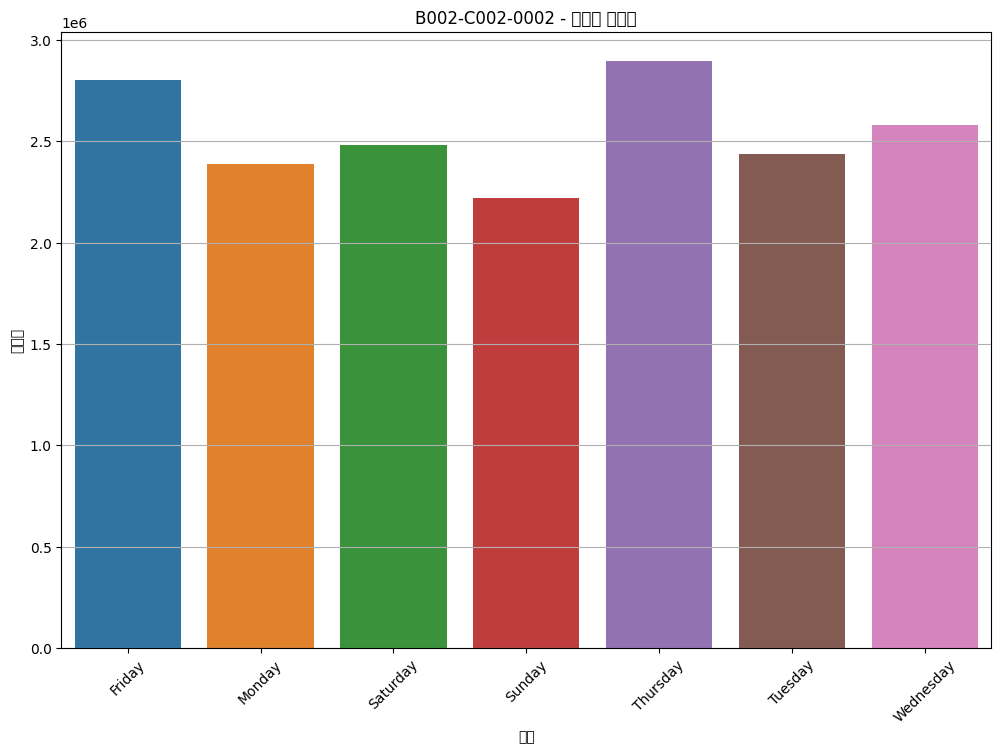

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

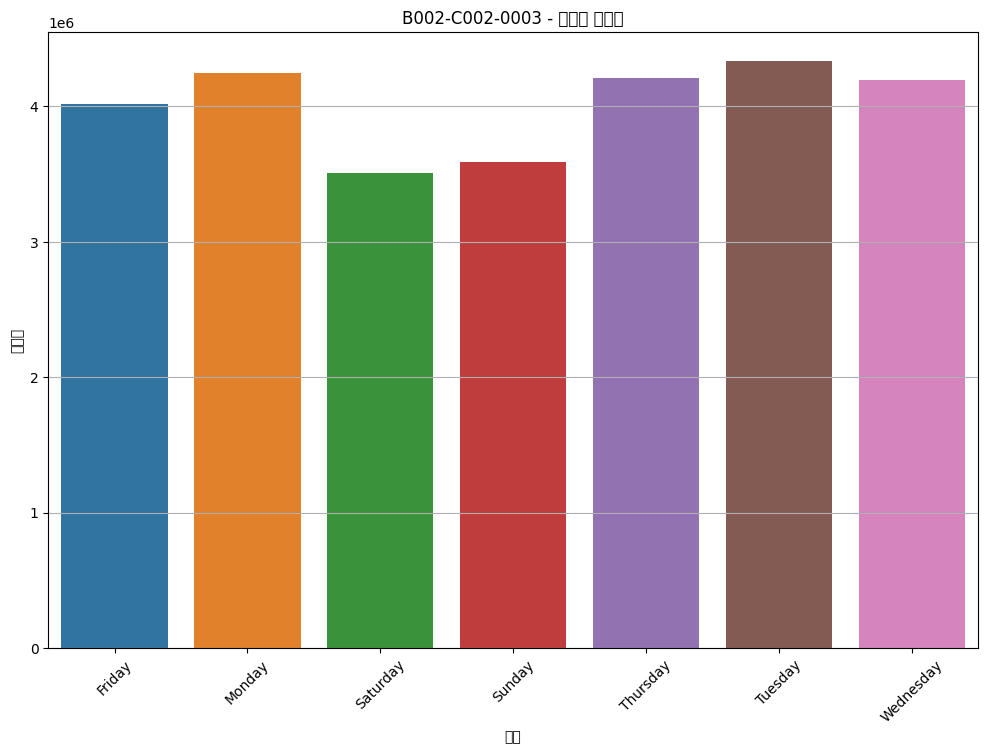

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

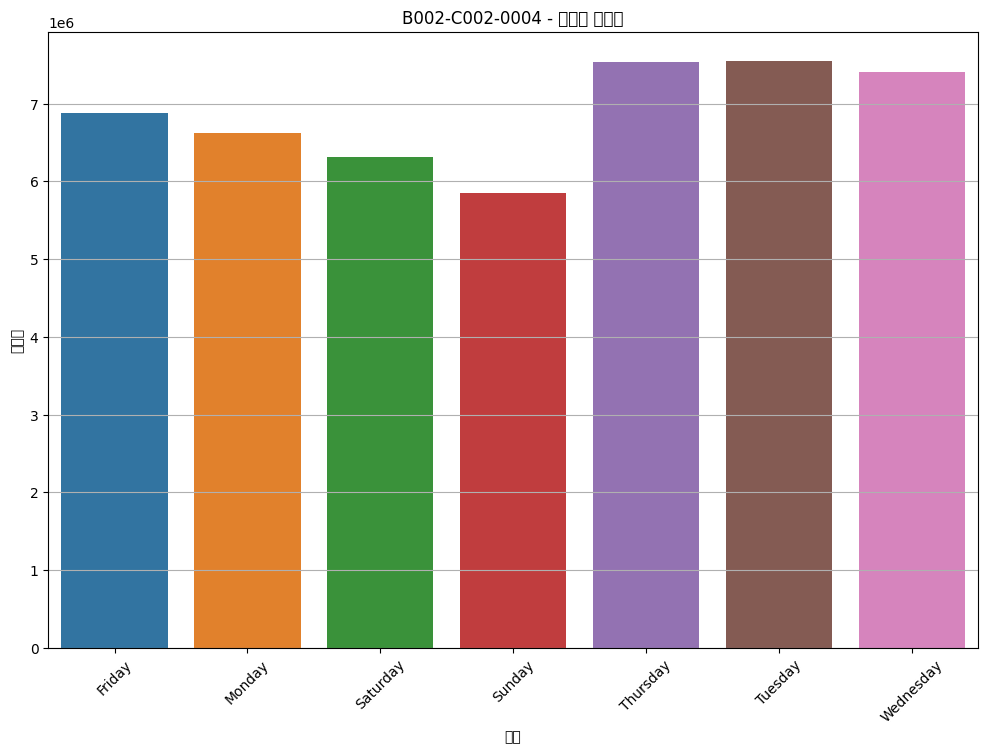

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

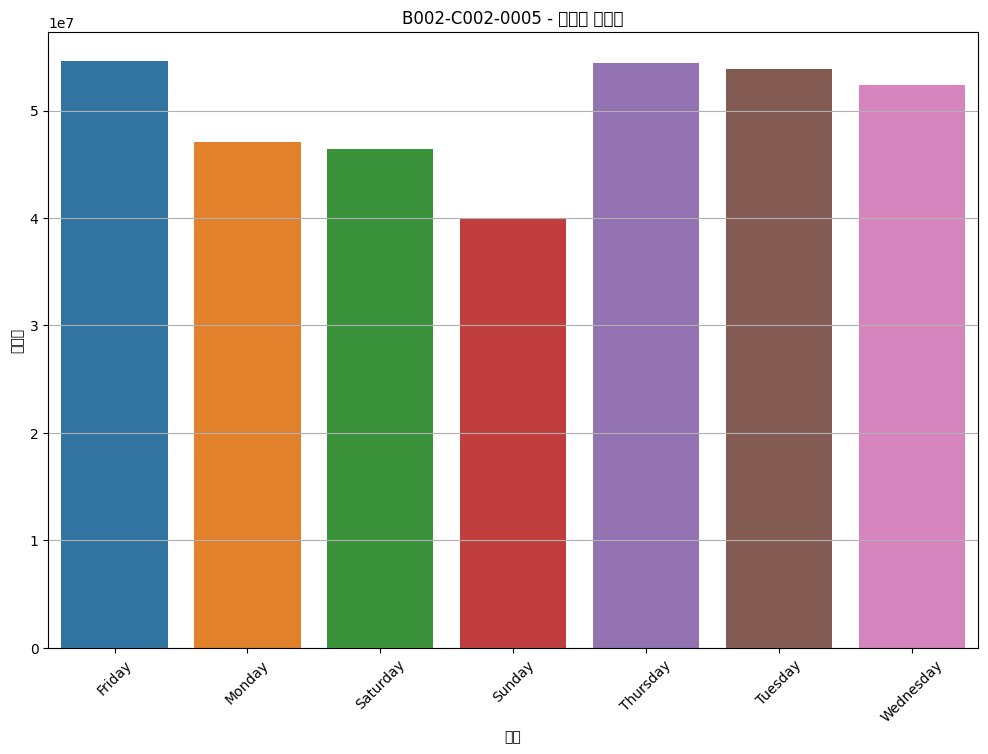

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

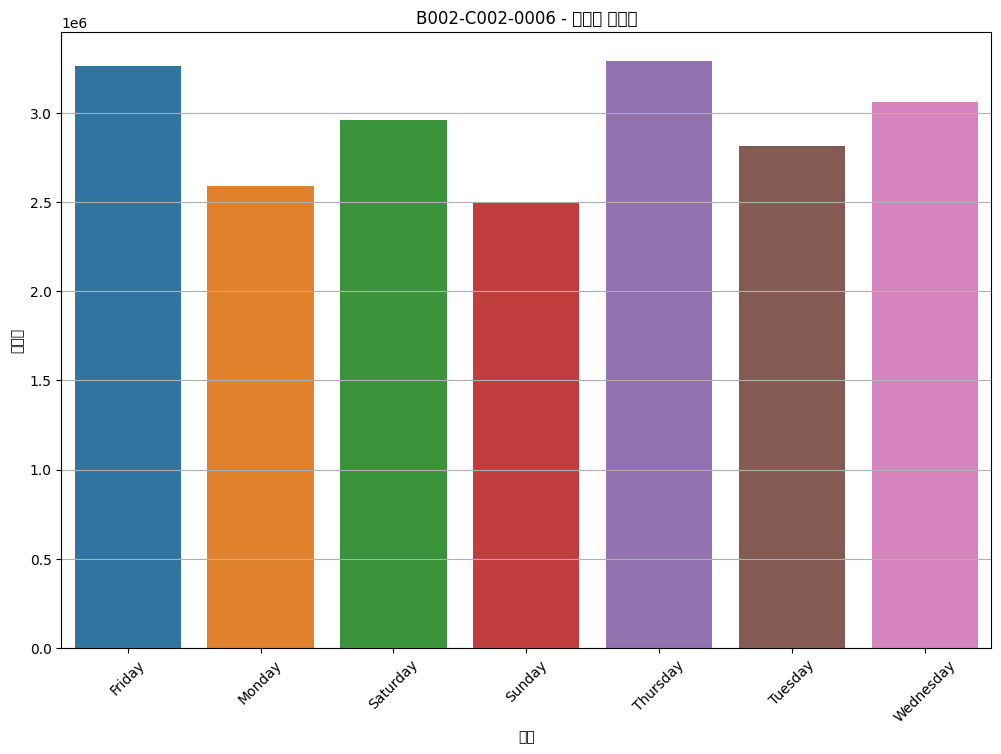

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

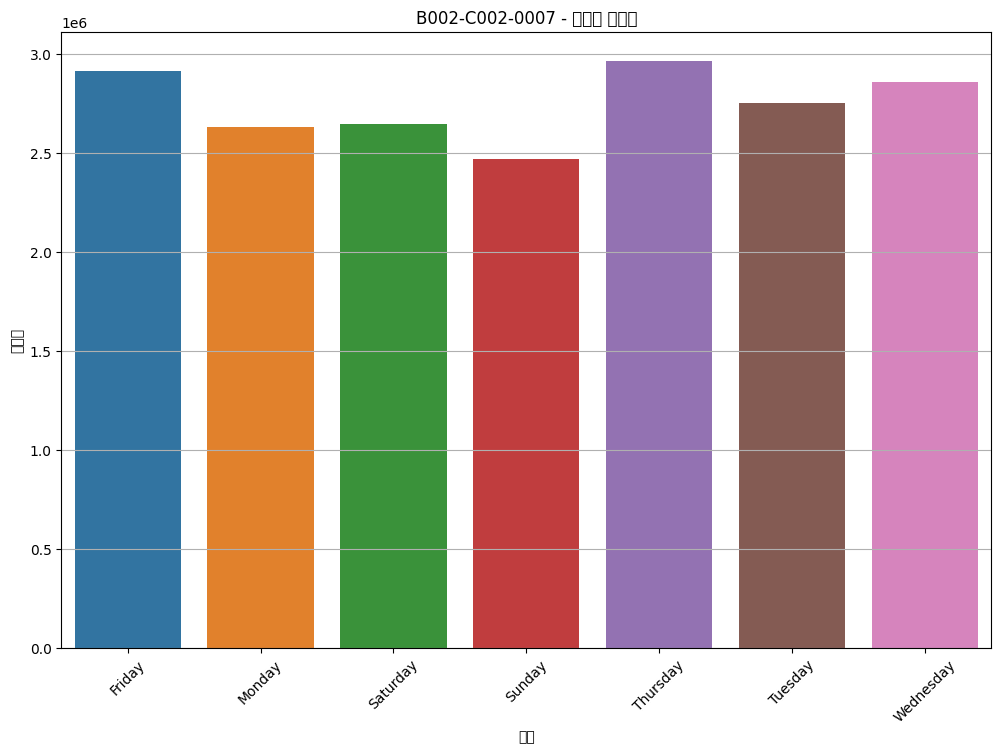

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

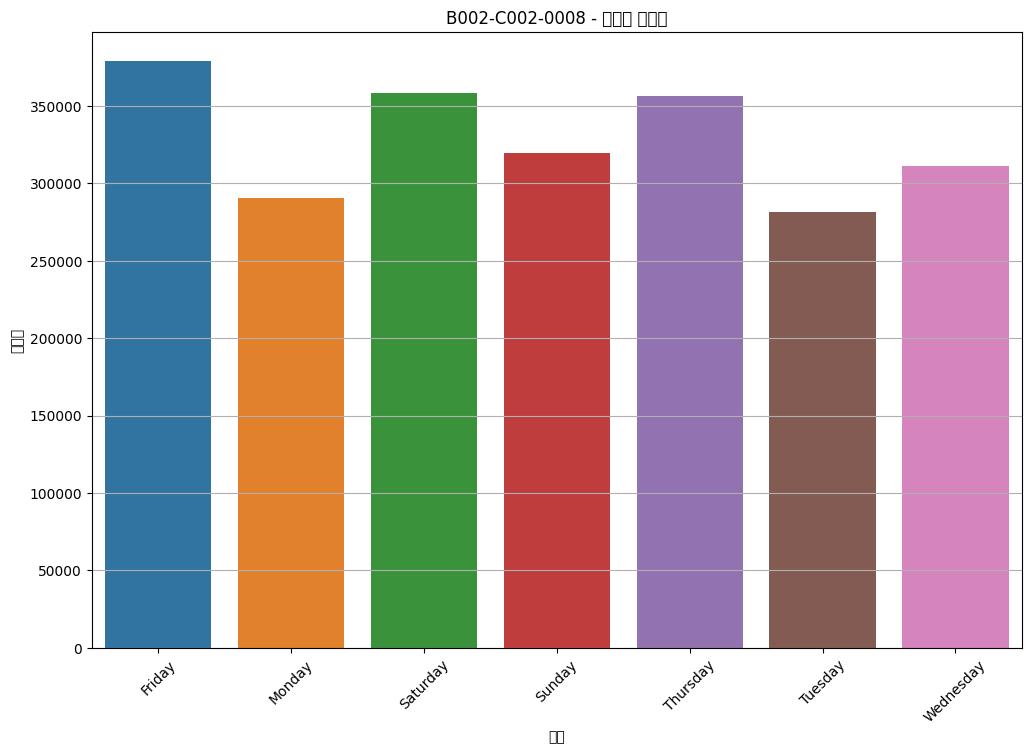

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

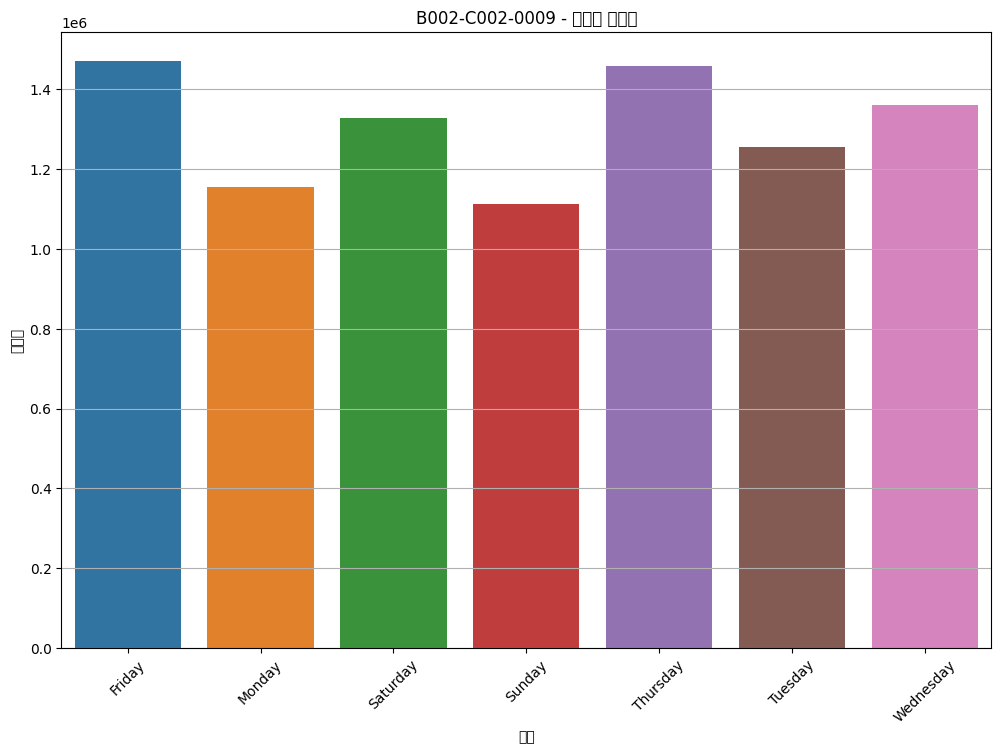

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

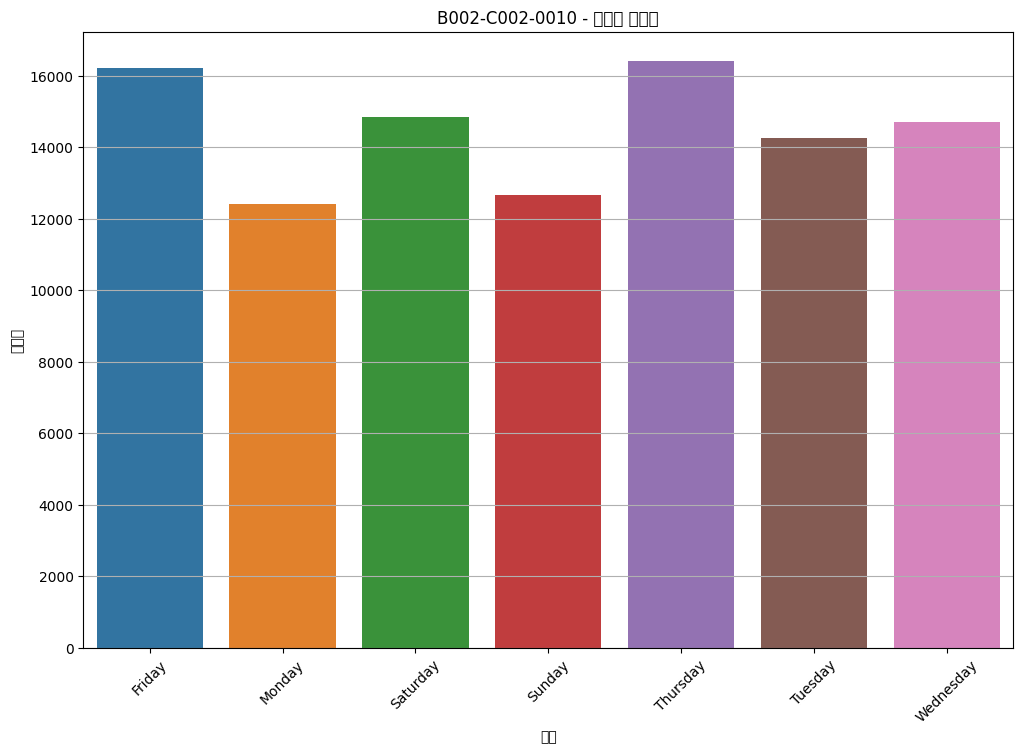

<ipython-input-46-14e938c5315c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-

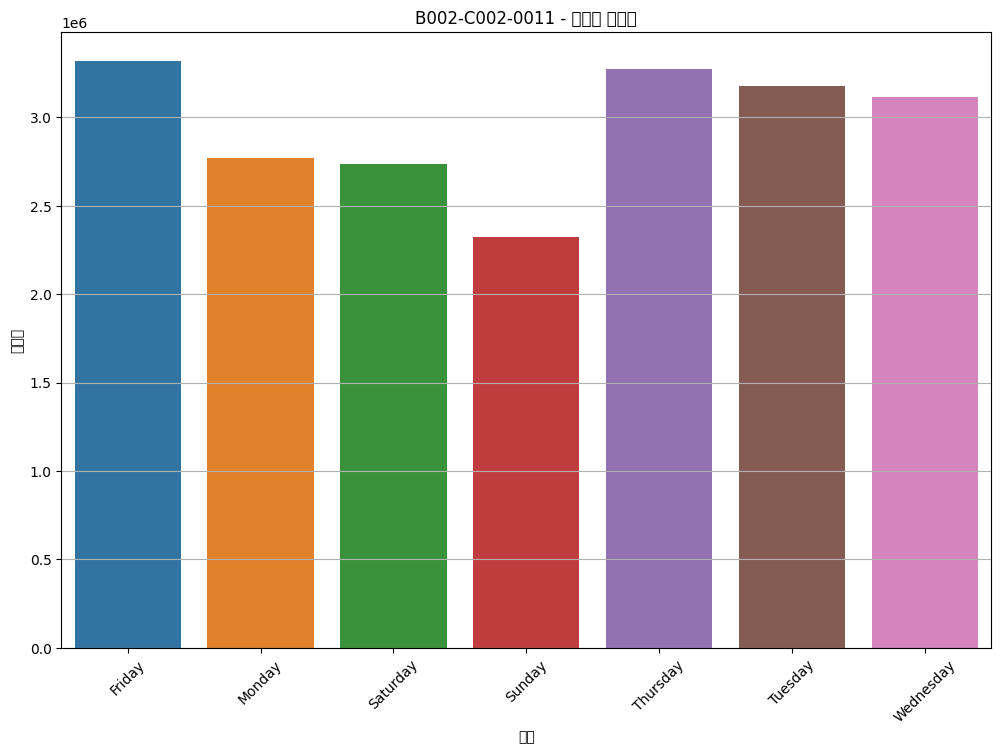

In [ ]:
# 중분류별로 각각의 막대 차트 생성
unique_categories = sales_by_day_and_category['중분류'].unique()

for category in unique_categories:
    category_sales = sales_by_day_and_category[sales_by_day_and_category['중분류'] == category]

    plt.figure()
    sns.barplot(x='day_of_week', y='sales', data=category_sales, ci=None)
    plt.title(f'{category} - 요일별 판매량')
    plt.ylabel('판매량')
    plt.xlabel('요일')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.show()


# processing(파생변수 생성)

### 판매가격 컬럼

In [ ]:
train = pd.read_csv("Data/train.csv")
sales = pd.read_csv("Data/sales.csv")

# # onesale : 제품당 판매가격
# # onesale = sales
result = []
i = 0
while i <= 28893: #486: #464->486
    k = 0
    t = list(train.loc[i,:])
    s = list(sales.loc[i,:])
    for j in range(7,486):
        if t[j] == 0:
            pass
        else:
            s[j] //= t[j]
            if k < s[j]:
              k = s[j]
    result.append(k)
    i+=1

train['판매가격'] = result

In [ ]:
last_column = train.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(train.columns[:-1])
# 7번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(7, last_column)

# 컬럼 순서 변경
train = train[new_order]

### 카테고리 컬럼

In [ ]:
hh = []
h = 0
while h <28894:
    ## 중분류 기준으로 '카테고리' 컬럼 추가
    pro = train.iloc[h][3]

    if pro == "B002-C002-0001":
        hh.append('건강기능식품')
    elif pro == "B002-C002-0002":
        hh.append('탈취/방충/살충/제습/방향')
    elif pro == "B002-C002-0003":
        hh.append('주방/청소/세탁세제')
    elif pro == "B002-C002-0004":
        hh.append('욕실용품')
    elif pro == "B002-C002-0005":
        hh.append('제지/위생용품')
    elif pro == "B002-C002-0006":
        hh.append('헤어/바디/스킨/면도')
    elif pro == "B002-C002-0007":
        hh.append('특수헤어용품')
    elif pro == "B002-C002-0008":
        hh.append('유아 생활용품')
    elif pro == "B002-C002-0009":
        hh.append('유아 위생용품')
    elif pro == "B002-C002-0010":
        hh.append('뷰티용품')
    else:
        hh.append('유아식품')
    h += 1

train['카테고리'] = hh

In [ ]:
last_column = train.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(train.columns[:-1])
# 8번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(8, last_column)

# 컬럼 순서 변경
train = train[new_order]

In [ ]:
train.drop(['중분류'],axis=1,inplace=True)

<ipython-input-180-24d1013c3e7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['중분류'],axis=1,inplace=True)


### 상위 20% 브랜드 컬럼

In [ ]:
# Calculate the total sales for each product
train['Total_Sales'] = train.iloc[:, 9:].sum(axis=1)

# Create a new column for "Top 20% Brand" and set default value to 'no'
train['상위 20% 브랜드'] = 'no'

# Calculate the 80th percentile of Total_Sales for each '대분류'
top_20_thresholds = train.groupby('대분류')['Total_Sales'].quantile(0.8)

# Set '상위 20% 브랜드' to 'yes' for products in the top 20% within their '대분류'
for category, threshold in top_20_thresholds.iteritems():
    train.loc[(df['대분류'] == category) & (train['Total_Sales'] > threshold), '상위 20% 브랜드'] = 'yes'

# Drop the temporary 'Total_Sales' column
train = train.drop(columns=['Total_Sales'])

# Move the '상위 20% 브랜드' column to the right of the '브랜드' column
cols = train.columns.tolist()
cols.insert(cols.index('쇼핑몰')+1, cols.pop(cols.index('상위 20% 브랜드')))
train = train[cols]

# Save the updated dataframe to a new CSV file again
train.to_csv('Data/train_TopBrand.csv', index=False)

<ipython-input-181-70afdd8dfdac>:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, threshold in top_20_thresholds.iteritems():


In [ ]:
# Load the data (train_TopBrand와 product_info file load)
train = pd.read_csv("Data/train_TopBrand.csv",index_col='ID')


In [ ]:
train

,제품,대분류,소분류,브랜드,쇼핑몰,상위 20% 브랜드,판매가격,카테고리,2022-01-01,2022-01-02,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
ID,,,,,,,,,,,,,,,,,,,,,
SAMPLE_00000,B002-00001-00001,B002-C001-0002,B002-C003-0038,B002-00001,S001-00001,no,13500,특수헤어용품,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMPLE_00001,B002-00002-00001,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,37800,유아 생활용품,0,0,...,2,0,2,0,2,2,1,0,0,0
SAMPLE_00002,B002-00002-00002,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,12900,유아 생활용품,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMPLE_00003,B002-00002-00003,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,5583,유아 생활용품,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMPLE_00004,B002-00002-00004,B002-C001-0003,B002-C003-0044,B002-00002,S001-00010,no,5225,유아 생활용품,0,0,...,10,6,4,4,4,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMPLE_28889,B002-03798-00046,B002-C001-0003,B002-C003-0044,B002-03798,S001-00001,no,16900,유아 생활용품,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMPLE_28890,B002-03799-00002,B002-C001-0003,B002-C003-0042,B002-03799,S001-00001,yes,2000,유아 생활용품,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMPLE_28891,B002-03799-00003,B002-C001-0003,B002-C003-0044,B002-03799,S001-00001,no,26400,유아 생활용품,0,0,...,2,4,1,0,0,0,4,0,2,0


### 가격분류 컬럼

In [ ]:
category_counts = train['카테고리'].value_counts()

# 빈 데이터프레임 생성
result_df = pd.DataFrame()

# 각 카테고리별로 처리
for category in category_counts.index:
    # 카테고리별 데이터 선택
    selected_rows = train[train['카테고리'] == category]

    # '판매 가격' 기준으로 내림차순 정렬
    selected_rows = selected_rows.sort_values(by='판매가격', ascending=False)

    # 길이를 3분할하여 '가격분류' 컬럼 추가
    num_rows = len(selected_rows)
    selected_rows['가격분류'] = pd.cut(range(num_rows), bins=3, labels=['상', '중', '하'])

    # 결과 데이터프레임에 추가
    result_df = pd.concat([result_df, selected_rows])

train=result_df.sort_values(by='ID')
train=train.reset_index()
# train.drop('index',axis=1,inplace=True)

train.head()

,ID,제품,대분류,소분류,브랜드,쇼핑몰,상위 20% 브랜드,판매가격,카테고리,2022-01-01,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,가격분류
0,SAMPLE_00000,B002-00001-00001,B002-C001-0002,B002-C003-0038,B002-00001,S001-00001,no,13500,특수헤어용품,0,...,0,0,0,0,0,0,0,0,0,중
1,SAMPLE_00001,B002-00002-00001,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,37800,유아 생활용품,0,...,0,2,0,2,2,1,0,0,0,상
2,SAMPLE_00002,B002-00002-00002,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,12900,유아 생활용품,0,...,0,0,0,0,0,0,0,0,0,중
3,SAMPLE_00003,B002-00002-00003,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,5583,유아 생활용품,0,...,0,0,0,0,0,0,0,0,0,하
4,SAMPLE_00004,B002-00002-00004,B002-C001-0003,B002-C003-0044,B002-00002,S001-00010,no,5225,유아 생활용품,0,...,6,4,4,4,0,0,0,0,8,하


In [ ]:
last_column = train.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(train.columns[:-1])
# 9번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(9, last_column)

# 컬럼 순서 변경
train = train[new_order]

### 대량판매 컬럼

In [ ]:
## EDA를 바탕으로 소분류에서 월별로 꾸준히 많이 팔리는 제품을 선정함.

good = ['0041','0003','0025','0004','0001','0052', '0022']
### 기저귀, 유산균, 물티슈, 단백질, 건강기능식품, 아기식품, 치약

h = 0
hh = []
while h < 28894:
    line = train.iloc[h][3]
    if line[10:] in good:
        hh.append('yes')
    else:
        hh.append('no')
    h += 1

train['대량판매'] = hh

In [ ]:
last_column = train.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(train.columns[:-1])
# 10번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(10, last_column)

# 컬럼 순서 변경
train = train[new_order]

train.to_csv('Data/train_off2.csv',index=False)

### 주기성 컬럼

In [ ]:
train = pd.read_csv('Data/train_off2.csv')

##EDA를 바탕으로 각 카테고리별 주기성 확인 가능. 이를 토대로 period 컬럼 생성

def period(x) :
    if x in ["건강기능식품", "유아 위생용품", "특수헤어용품"] :
        return "steady"
    elif x in ["유아 생활용품", "유아식품", "주방/청소/세탁세제", "헤어/바디/스킨/면도"] :
        return "5개월"
    elif x == "탈취/방충/살충/제습/방향" :
        return "1년"
    elif x == "욕실용품" :
        return "4개월"
    elif x == "제지/위생용품" :
        return "3개월"

train['period'] = train['카테고리'].apply(period)

last_column = train.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(train.columns[:-1])
# 11번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(11, last_column)

# 컬럼 순서 변경
train = train[new_order]

train.to_csv('Data/train_off3.csv',index=False)

In [ ]:
train

,ID,제품,대분류,소분류,브랜드,쇼핑몰,상위 20% 브랜드,판매가격,카테고리,가격분류,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,SAMPLE_00000,B002-00001-00001,B002-C001-0002,B002-C003-0038,B002-00001,S001-00001,no,13500,특수헤어용품,중,...,0,0,0,0,0,0,0,0,0,0
1,SAMPLE_00001,B002-00002-00001,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,37800,유아 생활용품,상,...,2,0,2,0,2,2,1,0,0,0
2,SAMPLE_00002,B002-00002-00002,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,12900,유아 생활용품,중,...,0,0,0,0,0,0,0,0,0,0
3,SAMPLE_00003,B002-00002-00003,B002-C001-0003,B002-C003-0044,B002-00002,S001-00001,no,5583,유아 생활용품,하,...,0,0,0,0,0,0,0,0,0,0
4,SAMPLE_00004,B002-00002-00004,B002-C001-0003,B002-C003-0044,B002-00002,S001-00010,no,5225,유아 생활용품,하,...,10,6,4,4,4,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28889,SAMPLE_28889,B002-03798-00046,B002-C001-0003,B002-C003-0044,B002-03798,S001-00001,no,16900,유아 생활용품,중,...,0,0,0,0,0,0,0,0,0,0
28890,SAMPLE_28890,B002-03799-00002,B002-C001-0003,B002-C003-0042,B002-03799,S001-00001,yes,2000,유아 생활용품,하,...,0,0,0,0,0,0,0,0,0,0
28891,SAMPLE_28891,B002-03799-00003,B002-C001-0003,B002-C003-0044,B002-03799,S001-00001,no,26400,유아 생활용품,상,...,2,4,1,0,0,0,4,0,2,0
28892,SAMPLE_28892,B002-03799-00004,B002-C001-0003,B002-C003-0044,B002-03799,S001-00001,no,14425,유아 생활용품,중,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
k = pd.read_csv('Data/train_off3.csv')
k.columns

Index(['ID', '제품', '대분류', '소분류', '브랜드', '쇼핑몰', '상위 20% 브랜드', '판매가격', '카테고리',
       '가격분류',
       ...
       '2023-04-15', '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19',
       '2023-04-20', '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24'],
      dtype='object', length=491)

In [ ]:
def day_week(x) :
    if x in ["건강기능식품", "탈취/방충/살충/제습/방향", "제지/위생용품", "헤어/바디/스킨/면도", "특수헤어용품", "뷰티용품"] :
        return "목요일"
    elif x in ["유아 생활용품", "유아식품", "유아 위생용품"] :
        return "금요일"
    elif x in ["주방/청소/세탁세제", "욕실용품"] :
        return "화요일"

k['day_week'] = k['카테고리'].apply(day_week)

In [ ]:
last_column = k.columns[-1]
# 맨 뒤의 컬럼을 제외한 모든 컬럼을 리스트에 추가
new_order = list(k.columns[:-1])
# 11번째 위치에 맨 뒤의 컬럼 삽입
new_order.insert(11, last_column)

In [ ]:
# 컬럼 순서 변경
k = k[new_order]

,가격분류,대량판매,day_week,period,2022-01-01,2022-01-02
0,중,no,목요일,steady,0,0
1,상,no,금요일,5개월,0,0
2,중,no,금요일,5개월,0,0
3,하,no,금요일,5개월,0,0
4,하,no,금요일,5개월,0,0
...,...,...,...,...,...,...
28889,중,no,금요일,5개월,0,0
28890,하,no,금요일,5개월,0,0
28891,상,no,금요일,5개월,0,0
28892,중,no,금요일,5개월,0,0


In [ ]:
k.to_csv('Data/train_off4.csv',index=False)

# Model

## 모델 파일(pt)를 저장할 경로

In [ ]:
# 모델의 종류, 변수의 종류가 변경될 때마다 수정해서 pt 파일을 저장할 경로 지정
path = 'PT/LSTM_fc_'

## Hyperparameter

In [ ]:
# 학습에 이용되는 변수 설정
CFG = {
    'TRAIN_WINDOW_SIZE':49, # 학습
    'PREDICT_SIZE':21, # 예측
    'EPOCHS':150, # 학습 횟수
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':256,
    'SEED':41
}

encoding_x = 6 # 모델에 사용되는 명목변수의 종류
split_rate = 0.2 # Validaion 데이터의 비율
step_size = 21 # 학습 데이터 생성 간격

## Fix Seed

In [ ]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [ ]:
# train 파일 불러오기
# columns=['ID',"제품","대분류","소분류","브랜드","상위 20% 브랜드", "카테고리", "대량판매","trend"])

train_data = pd.read_csv('Data/train_off4.csv').drop(columns=['ID',"제품","소분류","브랜드", "카테고리", "판매가격",'쇼핑몰'])

train_data.head(1)

,대분류,상위 20% 브랜드,가격분류,대량판매,day_week,period,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,B002-C001-0002,no,중,no,목요일,steady,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## RSFA metric

In [ ]:
# 제품별 대분류를 저장하기 위한 dictionary 생성
indexs_bigcat={}
for bigcat in train_data['대분류'].unique():
    indexs_bigcat[bigcat] = list(train_data.loc[train_data['대분류']==bigcat].index)

indexs_bigcat.keys()

# Validation 데이터에서 RSFA Score 계산을 위한 함수 구현
def PSFA(pred, target):
    PSFA = 1
    epsilon = 1e-10  # 매우 작은 값(분모가 0이 되는 것을 방지)

    for cat in indexs_bigcat.keys():
        ids = indexs_bigcat[cat]
        for day in range(21):
            total_sell = np.sum(target[ids, day]) # day별 총 판매량
            pred_values = pred[ids, day] # day별 예측 판매량
            target_values = target[ids, day] # day별 실제 판매량

            # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
            denominator = np.maximum(target_values, pred_values) + epsilon
            diffs = np.abs(target_values - pred_values) / denominator

            if total_sell != 0:
                sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
            else:
                sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

            if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
                PSFA -= np.sum(diffs * sell_weights) / (21 * 5)

    return PSFA

In [ ]:
# 사용자 Loss Fucntion 구현
## 일일 판매 비중을 계산하여 판매량이 높은 제품일수록 정확하게 예측하도록 유도
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true):
        # 일일 판매량의 절대 차이
        abs_diff = torch.abs(y_pred - y_true)

        # max(실제값, 예측값)
        max_values = torch.max(y_true, y_pred)

        # 특정 일의 모든 제품 판매량 합계
        sum_values = torch.sum(y_true, dim=1, keepdim=True)

        # 제품의 일일 판매량 실제값의 비중
        sales_weight = y_true / (sum_values + 1e-10)

        # 최종 손실 계산
        loss = torch.mean(sales_weight * (abs_diff / (max_values + 1e-10)))

        return loss

## Min-Max Scaling & Labeling

### Labeling

In [ ]:
# Apply Label Encoding("대분류","소분류","브랜드","상위 20% 브랜드", "카테고리", "대량판매", "trend")
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()
train_data['대분류'] = le1.fit_transform(train_data['대분류'])
# train_data['소분류'] = le2.fit_transform(train_data['소분류'])
# train_data['쇼핑몰'] = le3.fit_transform(train_data['쇼핑몰'])
train_data['상위 20% 브랜드'] = le4.fit_transform(train_data['상위 20% 브랜드'])
train_data['가격분류'] = le5.fit_transform(train_data['가격분류'])
train_data['대량판매'] = le6.fit_transform(train_data['대량판매'])
train_data['period'] = le6.fit_transform(train_data['period'])
train_data['day_week'] = le6.fit_transform(train_data['day_week'])

KeyError: ignored

### Scaling

In [ ]:
# 먼저 2D NumPy 배열로 변환
data_np = train_data.iloc[:, encoding_x:].values

# 최대 및 최소값 계산
max_vals = np.max(data_np, axis=1)
min_vals = np.min(data_np, axis=1)

# 분모가 0이되는 경우를 처리하려면 np.where를 사용하여 조건적으로 배열을 생성
denominator = np.where(max_vals == min_vals, 1, max_vals - min_vals)

# min-max scaling 수행
scaled_data = (data_np - min_vals[:, None]) / denominator[:, None]

# 결과를 DataFrame에 다시 저장
train_data.iloc[:, encoding_x:] = scaled_data

# 딕셔너리 생성
scale_max_dict = dict(enumerate(max_vals))
scale_min_dict = dict(enumerate(min_vals))

## Sliding

### Function

In [ ]:
from tqdm import tqdm
import numpy as np

def make_train_data(data, encoding_x = encoding_x, series = 1, train_size = CFG['TRAIN_WINDOW_SIZE'], predict_size = CFG['PREDICT_SIZE'], step_size=step_size):
    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = ((len(data.columns) - window_size) // step_size) + 1

    input_data = np.empty((num_rows * adjusted_size, train_size, series))
    encoding_data = np.empty((num_rows * adjusted_size, train_size, encoding_x))
    target_data = np.empty((num_rows * adjusted_size, predict_size))
    indices_data = np.empty((num_rows * adjusted_size), dtype=int)

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :encoding_x])
        sales_data = np.array(data.iloc[i, encoding_x:])

        for j in range(0, len(sales_data) - window_size + 1 - (window_size % step_size), step_size):
            window = sales_data[j: j + window_size]
            temp_data = window[:train_size]
            index = i * adjusted_size + j // step_size
            input_data[index] = temp_data.reshape(-1, 1)
            encoding_data[index] = np.tile(encode_info, (train_size, 1))
            target_data[index] = window[train_size:]
            indices_data[index] = i

    return input_data, encoding_data, target_data, indices_data

def make_predict_data(data, encoding_x=encoding_x, series=1, train_size=CFG['TRAIN_WINDOW_SIZE']):
    num_rows = len(data)
    indices_data = np.empty(num_rows, dtype=int)
    input_data = np.empty((num_rows, train_size, series))
    encoding_data = np.empty((num_rows, train_size, encoding_x))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :encoding_x])
        sales_data = np.array(data.iloc[i, encoding_x:])
        indices_data[i] = i

        window = sales_data[-train_size:]
        temp_data = window.reshape(-1, 1)
        input_data[i] = temp_data
        encoding_data[i] = np.tile(encode_info, (train_size, 1))

    return input_data, encoding_data, indices_data


### Run...

In [ ]:
# 학습 데이터 및 평가 데이터 생성
train_input, train_encoding, train_target, train_indices = make_train_data(train_data)
test_input, test_encoding, test_indices = make_predict_data(train_data)

100%|██████████| 28894/28894 [00:51<00:00, 560.60it/s]


## Split

In [ ]:
# Train / Validation Split
data_len = len(train_input)
split_idx = int(data_len * (1 - split_rate))

val_input, train_input = train_input[split_idx:], train_input[:split_idx]
val_encoding, train_encoding = train_encoding[split_idx:], train_encoding[:split_idx]
val_target, train_target = train_target[split_idx:], train_target[:split_idx]
val_indices, train_indices = train_indices[split_idx:], train_indices[:split_idx]

In [ ]:
train_input.shape, val_input.shape

((693456, 49, 1), (173364, 49, 1))

In [ ]:
train_encoding.shape, val_encoding.shape

((693456, 49, 6), (173364, 49, 6))

In [ ]:
train_target.shape, val_target.shape

((693456, 21), (173364, 21))

In [ ]:
train_indices.shape, val_indices.shape

((693456,), (173364,))

## CustomDataset

### Function

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

# 학습을 위한 CustomDataset 클래스
class CustomDataset(Dataset):
    def __init__(self, data_input, data_encoding, data_target, indices):
        self.data_input = data_input  # 데이터셋의 입력 특성
        self.data_target = data_target
        self.data_encoding = data_encoding
        self.indices = indices  # 원본 데이터에서의 행 인덱스

    def __len__(self):
        return len(self.data_input)  # 데이터셋의 크기를 반환

    def __getitem__(self, idx):
        x_input = self.data_input[idx].astype(np.float32)  # 주어진 인덱스에 대한 입력 특성을 가져오고 float32로 형변환
        x_encoding = self.data_encoding[idx].astype(np.float32)  # 주어진 인덱스에 대한 입력 특성을 가져오고 float32로 형변환
        original_idx = self.indices[idx]  # 샘플에 대한 원래 인덱스를 가져옴

        # data_target이 None이 아니라면 입력 특성과 목표 값을 모두 반환
        if self.data_target is not None:
            y = self.data_target[idx].astype(np.float32)  # 주어진 인덱스에 대한 목표 값을 가져오고 float32로 형변환
            return x_input, x_encoding, y, original_idx  # 입력 특성, 목표 값, 원래 인덱스를 반환
        else:
            return x_input, x_encoding, original_idx  # 목표 값이 없는 경우 입력 특성과 원래 인덱스만 반환

# 테스트를 위한 CustomDataset 클래스
class CustomDataset_Test(Dataset):
    def __init__(self, x_input, x_encoding, Y):
        self.x_input = x_input  # 데이터셋의 입력 특
        self.x_encoding = x_encoding  # 데이터셋의 입력 특성
        self.Y = Y  # 데이터셋의 목표 값 (None일 수 있음)

    def __getitem__(self, index):
        # 목표 값이 있는 경우, 입력 특성, 목표 값, 인덱스를 반환
        if self.Y is not None:
            return torch.Tensor(self.x_input[index]), torch.Tensor(self.x_encoding[index]), torch.Tensor(self.Y[index]), index  # 인덱스 추가하여 추적
        # 목표 값이 없는 경우, 입력 특성과 인덱스만 반환
        return torch.Tensor(self.x_input[index]), torch.Tensor(self.x_encoding[index]), index

    def __len__(self):
        return len(self.X)  # 데이터셋의 크기를 반환


### Run...

In [ ]:
train_dataset = CustomDataset(train_input,train_encoding, train_target, train_indices)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_encoding, val_target, val_indices)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## EarlyStoping

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0002, path=path):
        self.patience = patience  # 얼마나 많은 epoch 동안 개선이 없을 경우 학습을 멈출지 설정
        self.verbose = verbose  # 상세한 로그 출력 여부
        self.counter = 0  # 개선이 없는 epoch 횟수 카운터
        self.best_score = None  # 현재까지의 최고 점수
        self.early_stop = False  # Early stopping 여부
        self.val_loss_min = np.Inf  # 이전의 최소 검증 손실값
        self.delta = delta  # 개선이 되었다고 판단할 최소 변화량
        self.path = path  # 모델이 저장될 경로

    def __call__(self, val_loss, model):
        score = -val_loss  # 검증 손실을 점수로 변환 (손실은 작을수록 좋으므로 음수로 변환)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:  # 현재 점수가 이전 최고 점수보다 높지 않은 경우
            self.counter += 1
            if self.verbose:
                print(f'조기 종료 카운터: {self.counter} / {self.patience}')
            if self.counter >= self.patience:  # 카운터가 patience에 도달하면 조기 종료
                self.early_stop = True
        else:
            self.best_score = score  # 최고 점수 업데이트
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # 카운터 초기화

    def save_checkpoint(self, val_loss, model):
        '''검증 손실이 감소하면 모델을 저장합니다.'''
        if self.verbose:
            print(f'검증 손실이 감소했습니다. ({self.val_loss_min:.6f} --> {val_loss:.6f}).  모델 저장 ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss  # 최소 검증 손실 업데이트

    def get_val_loss_min(self):
        return self.val_loss_min  # 현재까지의 최소 검증 손실값을 반환


## Model 구조 생성

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, encoding_dim = encoding_x, series_dim=1, hidden_size=256, output_size=CFG['PREDICT_SIZE'], num_layers=2):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size  # 은닉층의 노드 수

        # LSTM 층 설정
        self.lstm = nn.LSTM(input_size = encoding_x + series_dim, hidden_size=hidden_size, batch_first=True)

        # 완전 연결층 (Fully Connected Layer)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),  # 선형 층 이후에 배치 정규화 추가
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )

        # 활성화 함수로 ReLU 사용
        self.actv = nn.ReLU()

    def forward(self, series_input, encoding_input):
        # Combining series_input and encoding input
        combined_input = torch.cat((series_input, encoding_input), dim=2)

        batch_size = combined_input.size(0)
        # 초기 은닉 상태와 셀 상태 설정
        hidden = self.init_hidden(batch_size, combined_input.device)

        # LSTM 층을 통과
        lstm_out, hidden = self.lstm(combined_input, hidden)

        # 마지막 출력 시퀀스만 사용
        last_output = lstm_out[:, -1, :]

        # 완전 연결층을 통과
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # 은닉 상태와 셀 상태 초기화
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))
        return x

### Train Function

In [ ]:
def train(model, optimizer, train_loader, val_loader, device):
    # 모델을 지정한 디바이스로 옮김
    model.to(device)
    best_psfa = 0  # 최고 PSFA 점수를 저장할 변수
    best_loss = 99999  # 최저 손실값을 저장할 변수

    # 사용자 정의 손실 함수 초기화
    criterion = CustomLoss().to(device)

    # CosineAnnealingLR 스케줄러 초기화
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG['EPOCHS'])

    # Epoch에 따라 Train과 Valdiation을 수행
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()  # 모델을 훈련 모드로 설정
        train_loss = []

        # 훈련 데이터로 모델 훈련
        for data_input, data_encoding, data_target, indices in tqdm(iter(train_loader)):
            data_input = data_input.to(device)
            data_encoding = data_encoding.to(device)
            data_target = data_target.to(device)

            # 기울기 초기화
            optimizer.zero_grad()

            # 순방향 계산
            output = model(data_input, data_encoding)
            loss = criterion(output, data_target)

            # 역방향 계산 및 파라미터 업데이트
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # 검증 데이터로 모델 검증 및 로그 출력
        val_loss, psfa_score = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] PSFA Score : [{psfa_score:.5f}]')

        # 손실값이 최소일 때 모델 저장
        if best_loss > val_loss:
            best_loss = val_loss
            best_model_loss = model
            torch.save(model.state_dict(), path + 'Model(best)_Loss.pt')

        # PSFA 점수가 최대일 때 모델 저장
        if best_psfa < psfa_score:
            best_psfa = psfa_score
            best_model_psfa = model
            torch.save(model.state_dict(), path + 'Model(best)_PSFA.pt')

        # 조기 종료 로직 실행
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            print(f"Best saved validation loss: {early_stopping.get_val_loss_min():.6f}")
            break

        # 스케줄러 갱신
        scheduler.step()

    return best_loss, best_psfa

### Validation Function

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    val_loss = []  # 검증 손실을 저장할 리스트
    pred_list = []  # 예측 값을 저장할 리스트
    target_list = []  # 실제 타겟 값을 저장할 리스트
    indices = []  # 배치의 인덱스를 저장할 리스트

    # 기울기 계산을 하지 않는 블록
    with torch.no_grad():
        # 검증 데이터로 모델 평가
        for data_input, data_encoding, data_target, i in tqdm(iter(val_loader)):
            data_input = data_input.to(device)
            data_encoding = data_encoding.to(device)
            data_target = data_target.to(device)
            output = model(data_input, data_encoding)

            # 손실 계산
            loss = criterion(output, data_target)
            val_loss.append(loss.item())

            # 예측값과 타겟을 CPU로 이동 후 NumPy 배열로 변환
            output = output.cpu().numpy()
            data_target = data_target.cpu().numpy()

            # 예측값과 타겟을 리스트에 저장
            pred_list.extend(output)
            target_list.extend(data_target)
            indices.extend(i.cpu().numpy())

    # 예측값과 타겟을 NumPy 배열로 변환
    pred_array = np.array(pred_list)
    target_array = np.array(target_list)

    # 각 예측값과 타겟을 스케일링
    for i, idx in enumerate(indices):
        pred_array[i, :] = pred_array[i, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
        target_array[i, :] = target_array[i, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

    # 예측값과 타겟을 반올림
    pred_array = np.round(pred_array, 0).astype(int)
    target_array = np.round(target_array, 0).astype(int)

    # PSFA 점수 계산
    psfa_score = PSFA(pred_array, target_array)

    return np.mean(val_loss), psfa_score  # 평균 검증 손실과 PSFA 점수 반환

### Train 진행

In [ ]:
# epoch 설정
save_model_loss = None  # 저장할 모델의 손실값 초기화

# Model과 Optimizer 설정
model = BaseModel()  # 기본 모델 인스턴스 생성
optimizer = torch.optim.AdamW(params=model.parameters(), lr=CFG["LEARNING_RATE"])  # AdamW 옵티마이저 사용

# Early Stopping 객체 생성
early_stopping = EarlyStopping(patience=20, verbose=True, path=path + 'Model_earlystop.pt')  # 일찍 멈추기 설정 (20회 동안 개선이 없으면 훈련 중단)

# 훈련 함수 호출 및 최고 점수 반환 받기
best_loss, best_psfa = train(model, optimizer, train_loader, val_loader, device)  # 훈련 실행하고 최고의 손실값과 PSFA 점수를 가져옴

# 최고 점수 출력
print(f' Best PSFA Score : [{best_psfa:.5f}]')  # 최고 PSFA 점수 출력
print(f' Best Loss Score : [{best_loss:.5f}]')  # 최고 손실 점수 출력

### 추론 과정

#### Load Save Model

In [ ]:
# 동일한 구조의 모델 객체를 생성
infer_model = BaseModel()  # 추론(inference)을 위한 새 모델 객체 생성

# 가장 좋은 RSFA 모델의 가중치를 불러오기 위한 경로 설정
best_model_rsfa_path = path + 'Model(best)_Loss.pt'  # 가장 좋은 RSFA 모델의 저장 경로

# 미리 훈련된 모델의 가중치 불러오기
infer_model.load_state_dict(torch.load(best_model_rsfa_path))  # 훈련된 가중치를 새 모델에 로드

# 모델을 디바이스(GPU 또는 CPU)로 이동
infer_model.to(device)  # 모델을 실행 디바이스로 옮김 (GPU)

# 모델을 추론 모드로 설정
infer_model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등을 고정)

BaseModel(
  (lstm): LSTM(7, 256, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=21, bias=True)
  )
  (actv): ReLU()
)

#### Make Test Dataset

In [ ]:
test_dataset = CustomDataset(test_input, test_encoding, None, test_indices)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

#### Inference & Inverse Scaling

* Function

In [ ]:
# 모델을 사용하여 테스트 데이터에 대한 추론을 수행하는 함수 정의
def inference(model, test_loader, device):
    predictions = []  # 예측값을 저장할 리스트

    with torch.no_grad():
        # 테스트 로더에서 배치 단위로 데이터 가져오기
        for data_input, data_encoding, _ in tqdm(test_loader):  # '_'는 사용하지 않는 index 값을 무시하기 위해 사용
            data_input = data_input.to(device)
            data_encoding = data_encoding.to(device)  # 데이터를 실행 디바이스로 옮김 (GPU)
            output = model(data_input, data_encoding)  # 모델을 통해 예측 수행
            output = output.cpu().numpy()  # 예측 결과를 Numpy 배열로 변환
            predictions.extend(output)  # 예측 결과를 리스트에 추가

    return np.array(predictions)  # Numpy 배열로 반환

* Run...

In [ ]:
# 추론 함수 호출
pred = inference(infer_model, test_loader, device)

# 추론 결과에 역정규화 (inverse scaling) 적용
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리: 소수점 반올림 후 정수로 변환
pred = np.round(pred, 0).astype(int)

100%|██████████| 113/113 [00:00<00:00, 139.67it/s]


#### Submission

In [ ]:
submit = pd.read_csv('Data/sample_submission.csv')
submit.head()

submit.iloc[:,1:] = pred
submit.head()

submit.to_csv('Sumbit/LSTM_fc_best+.csv', index=False)